# Tweet Emotion Classification

- **Author**: Ciro Ogliastro
- **Date**: 01/2026
- **Course**: Natural Language Processing

This project implement a deep learning pipeline for text classification in tweets across 6 categories (sandess, joy, anger, love, fear, surprise).

I compared a baseline of Embeddings + MLP with a LSTM with Attention. Emotion Classification is a multi-label text classification task. The Model with attention achieved 90.87% F1-macro score on a dataset of 425.000 tweets.


# Environment Setup

In [71]:
# All the Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import datasets
import pandas as pd
import random
import os
from collections import Counter
import re
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score, confusion_matrix, matthews_corrcoef, classification_report
from collections import defaultdict
import shutil

In [72]:
# Save/Load models here
save_path = "/content/drive/My Drive/Colab Notebooks/NLP Exam/"

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
# Import and download nltk tokenizer and stop words
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer

nltk.download('punkt_tab')

from nltk import ngrams
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

The following code set the seed necessary to reproduce this experiment.

In [74]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

# Data Acquisition

## Datasets Composition
I combined together three datasets:
- The first dataset comes from Saravia et al., "CARER: Contextualized Affect Representations for Emotion Recognition," EMNLP 2018. It is composed of about 416k rows of data, composed of a text (a tweet) and emotions row (which labels: sadness, joy, love, anger, fear and surprise)
- The first dataset comes from the SemEval Workshop of 2018 (see https://huggingface.co/datasets/SemEvalWorkshop/sem_eval_2018_task_1). This dataset has some differences in the labels, but i mapped them into the first dataset
- The last dataset comes from https://github.com/RoozbehBandpey/ELTEA17/tree/main. The label are a bit different so i had to do a mapping of the labels.

The label distribution is practically invariate, it remains unbalanced, but this is documented later.

At the end of this section i will have an unprocessed dataset of 425k rows, where each is labeled as one of the six labels from Saravia et al.,

In [4]:
# Clone the repo
if not os.path.exists("twitter_emo_classification"):
  !git clone https://github.com/moka-co/twitter_emo_classification.git
  %cp twitter_emo_classification/data/* .

Cloning into 'twitter_emo_classification'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 37 (delta 16), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 19.56 MiB | 16.26 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [5]:
dataset = pd.read_pickle("merged_training.pkl")

GloVe (Global Vectors for Word Representation) is an unsupervised learning algorithm that converts words into dense vectors based on their global co-occurrence statistics.

By analyzing how often words appear together across a massive text corpus, it maps them into a multi-dimensional space where mathematical distance represents semantic meaning (e.g., "king" and "queen" will be geometrically close).

I will use GloVe embeddings as pre embedded layer, so that a word in my dictionary will start with the GloVe representation instead of having to learn the embeddings from scratch.

In [6]:
# Get Glove embeddings
if not os.path.exists("glove.6B.zip"):
  print("🚀 Starting GloVe download...")
  !wget -q http://nlp.stanford.edu/data/glove.6B.zip
  !unzip glove.6B.zip > /dev/null 2>&1 &
  print("Finished GloVe download")


# Function that defines a glove embeddings matrix
def load_glove_embeddings(path, word2idx, embedding_dim=100):
    """
    path: path to glove.6B.100d.txt
    word2idx: dictionary mapping words to integers from your dataset
    """
    vocab_size = len(word2idx)
    # Initialize matrix with random values (or zeros)
    embedding_matrix = torch.randn(vocab_size, embedding_dim)
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in word2idx:
                vector = torch.tensor([float(x) for x in values[1:]])
                idx = word2idx[word]
                embedding_matrix[idx] = vector

    return embedding_matrix

🚀 Starting GloVe download...
Finished GloVe download


In [7]:
dataset2 = None

if not os.path.exists("SemEval2018-Task1-all-data.zip"):
  !wget -q https://saifmohammad.com/WebDocs/AIT-2018/AIT2018-DATA/SemEval2018-Task1-all-data.zip
  !unzip -q SemEval2018-Task1-all-data.zip
  !rm -r __MACOSX/

sem_eval_path_train = "/content/SemEval2018-Task1-all-data/English/E-c/2018-E-c-En-train.txt"
sem_eval_path_val = "/content/SemEval2018-Task1-all-data/English/E-c/2018-E-c-En-test-gold.txt"

dict_semeval_columns = ['tweet_id','text','anger', 'anticipation', 'disgust', 'fear', 'joy',
    'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'
]

dataset2 = pd.read_csv(sem_eval_path_train,
        sep='\t',
        header=0,
        names=dict_semeval_columns
    )

In [8]:
dataset2.head()

,tweet_id,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


I'm going to merge the two dataset together. As criteria, i'm selecting only the rows from the dataset 2 that are compatible with dataset 1 i.e rows labeled with 1 only if the label is present in the first set of labels.

First i want to check if there are any duplicates i.e text contained in both dataset

In [9]:
# Check duplicates
duplicates = [dataset2["text"].isin(dataset["text"])]
print(f"Duplicates: {len(duplicates)}")

Duplicates: 1


In [10]:
# Merge dataset2 with dataset 1
df = dataset
emotion_to_id = dict(enumerate(df['emotions'].astype('category').cat.categories))

# Filter rows
def filter_rows(target_df, emotion_mapping):
    """
    Returns rows where none of the specified emotions are present (all 0s).
    """
    # Extract the emotion names from your dictionary
    target_emotions = list(emotion_mapping.values())

    # Filter only the columns that actually exist in the dataframe to avoid KeyErrors
    existing_cols = [col for col in target_emotions if col in target_df.columns]

    # Sum the emotion columns value horizontally (axis=1) and keep rows where the sum is 0
    mask = target_df[existing_cols].sum(axis=1) == 0
    negative_df = target_df[mask].copy()

    print(f"✅ Filtered {len(negative_df)} rows out of {len(target_df)}")
    return negative_df

negative = filter_rows(dataset2, emotion_to_id) # Dataset containing only rows with label not present in dataset1

# take only compatible rows:
positive = dataset2[~dataset2.index.isin(negative.index)]

# Create semeval_subset directly from positive text
semeval_subset = pd.DataFrame({
    'text': positive['text'].values
}, index=positive.index)

# 2. Identify which columns in 'positive' map to our target emotions
alignment_map = {
'anger': 'anger',
'fear': 'fear',
'joy': 'joy',
'love': 'love',
'sadness': 'sadness',
'surprise': 'surprise',
'disgust': 'anger' # Common academic grouping: Disgust often maps to Anger
}

present_cols = [col for col in alignment_map.keys() if col in positive.columns]

semeval_subset['emotions'] = positive[present_cols].any(axis=1).astype(int)
def map_to_primary(row):
    for col in present_cols:
        if row[col] == 1:
            return alignment_map[col]


semeval_subset['emotions'] = positive.apply(map_to_primary, axis=1)

✅ Filtered 591 rows out of 6838


In [11]:
# Visualize that now it has the desired structure
semeval_subset.head()

,text,emotions
1,Whatever you decide to do make sure it makes y...,joy
2,@Max_Kellerman it also helps that the majorit...,anger
3,Accept the challenges so that you can literall...,joy
4,My roommate: it's okay that we can't spell bec...,anger
5,No but that's so cute. Atsu was probably shy a...,joy


In [12]:
df.head()

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


In [13]:
# Merge the two datasets
merged_dataset = pd.concat([dataset, semeval_subset], ignore_index=True)
merged_dataset.describe()

,text,emotions
count,423056,423056
unique,400068,6
top,i feel more adventurous willing to take risks,joy
freq,16,143185


In [14]:
df = merged_dataset

In [15]:
# Download dataset 3
!rm train.txt
!wget https://raw.githubusercontent.com/RoozbehBandpey/ELTEA17/refs/heads/main/datasets/train.txt

dataset3_raw = pd.read_csv("./train.txt", sep='|', header=None, names=['emotions', 'sarcasm', 'text'])

rm: cannot remove 'train.txt': No such file or directory
--2026-01-13 10:59:27--  https://raw.githubusercontent.com/RoozbehBandpey/ELTEA17/refs/heads/main/datasets/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230265 (225K) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>] 224.87K  --.-KB/s    in 0.002s  

2026-01-13 10:59:27 (96.3 MB/s) - ‘train.txt’ saved [230265/230265]



In [16]:
dataset3_raw.head()

,emotions,sarcasm,text
0,joy,N,That is one #happy #dog who never ceases to ma...
1,sad,S,Because everyone knows Arsenal are desperate t...
2,dis,N,You say that I'm paranoid but I'm pretty sure ...
3,joy,N,One of London's best days and showing the worl...
4,sad,N,More children will die because govt not trying...


In [17]:
dataset3_raw.head()
df3 = dataset3_raw.drop(columns=['sarcasm'])
df3.head()

,emotions,text
0,joy,That is one #happy #dog who never ceases to ma...
1,sad,Because everyone knows Arsenal are desperate t...
2,dis,You say that I'm paranoid but I'm pretty sure ...
3,joy,One of London's best days and showing the worl...
4,sad,More children will die because govt not trying...


In [18]:
print(pd.unique(df3["emotions"]))
conversion_map_df3 = {"joy" : "joy", "sad" : "sadness", "dis" : "anger", "ang" : "anger", "fea": "fear", "sup" : "surprise"}
df3["emotions"] = df3["emotions"].map(conversion_map_df3)
print("\nAfter conversion:")
print(pd.unique(df3["emotions"]))

['joy' 'sad' 'dis' 'fea' 'ang' 'sup']

After conversion:
['joy' 'sadness' 'anger' 'fear' 'surprise']


In [19]:
df3.describe()

,emotions,text
count,1997,1997
unique,5,1997
top,anger,If we die from nuclear war before I get to see...
freq,576,1


In [20]:
# Check duplicates
duplicates = [df3["text"].isin(df["text"])]
print(f"Duplicates: {len(duplicates)}")
duplicates = [df["text"].isin(df3["text"])]
print(f"Duplicates: {len(duplicates)}")

Duplicates: 1
Duplicates: 1


In [21]:
merged_dataset = pd.concat([df, df3], ignore_index=True)

In [22]:
print(len(df))
print(len(merged_dataset))

423056
425053


In [23]:
df = merged_dataset

In [24]:
print(pd.unique(df["emotions"]))

['sadness' 'joy' 'love' 'anger' 'fear' 'surprise']


In [25]:
# print longest text message
idx_max_words = df['text'].str.split().str.len().idxmax()
max_words = len(df.loc[idx_max_words, 'text'].split())

print(f"\nMax Word Count: {max_words}")
print(f"Tweet: {df.loc[idx_max_words, 'text']}")

# Removing this single tweet for visualization purposes
df = df.drop(idx_max_words)


Max Word Count: 717
Tweet: it's kind of sad how we always seem to fall for people who never have one for us and ignore the ones who look at us like we're angels."
sad|N|I'm a swallower of anger I'm the tree that falls and makes no sounds.
joy|N|I love this beautiful & talented angel with all of my heart. I'm so proud of her for her new film & I know she's good.
ang|N|If You still support #Trump FUCK YOU !! Because all He stands for is #hate greed & destruction.
dis|N|#mccannyou will be remembered for killing 150+ on the USS Forresthal a lost presidential election and your big mouth.
sad|N|I can't even play football this year because of my back
fea|N|Finally catching up on news: 1) Trump made up his response to NK on the fly. 2) Trump is lying about our nuclear arsenal. We're screwed.
ang|N|Celebrities #Outraged By #Trump Tweet Saying #Transgender People Not Allowed To Serve In US #Military.
ang|N|I need some real help. Banging head against brick wall!! Do you have a live chat option a

# Preprocessing Pipeline
**What is a token**: in my experiment i'm going to consider tokens as words in a tweet separated by whitespace. I'm going to drop puntuation.

I keep some characters like "@" because Users are different from i.e words that may be contained in the users. I keep "#" because hashtag are different and carry a different meaning from word. I keep "?" and "!" because they are import and often find in surprise or anger tweets. I keep "." for elipses "..." that also carry emotional information.

I apply the following PreprocessPipeline:


In [28]:
class PreprocessPipeline:
  def __init__(self):
    self.tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

    # List of chars to keep
    # point is keep for elipses "..."
    chars_to_keep = "@#?!.'"
    self.punct_to_remove = "".join([c for c in string.punctuation if c not in chars_to_keep])

  def clean_text(self, text):
    # Lower
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\b(href|http|https)\b', '', text)

    # Some noise patterns found
    noise_patterns = [
        r'gt',
        # This version catches "class delicious", "class-delicious", or "class=delicious"
        r'class[^\w\s]*delicious[^\w\s]*title[^\w\s]*share[^\w\s]*del', # Removes 'gt' (from >)
        r'rel[^\w\s]*nofollow[^\w\s]*target[^\w\s]*blank',              # Specific CSS/HTML string
        r'languagedirection[^\w\s]*ltr',                                 # Specific CSS/HTML string
        r'\b(type|application|atom|xml|feedlinks|href|http|https)\b',     # Directional metadata
    ]

    noise_patterns = [
        r'\bgt\b',
        r'class delicious title share del',
        r'\b(type|application|atom|xml)\b',
        r'rel nofollow target blank',                   # Link attributes
        r'feedlinks',                                   # Feed links
        r'languagedirection ltr'                        #
    ]
    combined_noise = '|'.join(noise_patterns)
    text = re.sub(combined_noise, '', text)

    # Remove puntuation, keep some special characters
    # We use a translation table here; it's much faster than regex for single characters
    table = str.maketrans('', '', self.punct_to_remove)
    text = text.translate(table)

    text = re.sub(combined_noise, '', text) # re apply

    # Remove extra space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

  def transform(self, text):
    text = self.clean_text(text)
    tokens = self.tweet_tokenizer.tokenize(text)
    return tokens

In [29]:
pipeline = PreprocessPipeline()

# Exploratory Data Analysis
We have a total of 425k labeled samples with 6 emotions: ['sadness' 'joy' 'love' 'anger' 'fear' 'surprise']

In [32]:
df.describe()
print(pd.unique(df['emotions']))

,token_count
count,425052.000000
mean,19.155906
std,10.990976
min,1.000000
25%,11.000000
50%,17.000000
75%,25.000000
max,178.000000


I add a label for each emotion for making data easier to works with

In [34]:
id_to_emotion = {0: 'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
emotion_to_id = {'sadness':0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}
df['label_id'] = df['emotions'].map(emotion_to_id)

df.head()

,text,emotions,token_count,label_id
0,i feel awful about it too because it s my job ...,sadness,26,0
1,im alone i feel awful,sadness,5,0
2,ive probably mentioned this before but i reall...,joy,27,1
3,i was feeling a little low few days back,sadness,9,0
4,i beleive that i am much more sensitive to oth...,love,18,2


In [35]:
# Custom colors for emotions
custom_palette = {
    'anger': '#FF4B4B',    # Red
    'joy': '#228B22',       # Forest Green
    'sadness': '#1E90FF',  # Blue
    'fear': '#800080',     # Purple
    'love': '#FF69B4',     # Pink
    'surprise': '#FFA500'  # Orange
}

emotions
joy         0.337919
sadness     0.287626
anger       0.142187
fear        0.114807
love        0.081374
surprise    0.036087
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Distribution of Emotions')

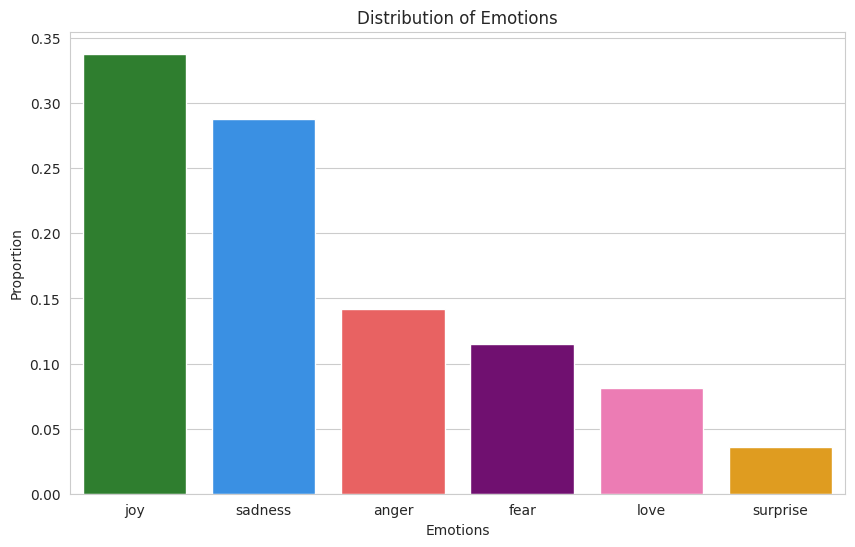

In [36]:
# Compute proportions
distributions=df['emotions'].value_counts(normalize=True)
print(distributions)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.countplot(data=df, x='emotions', order = distributions.index, palette=custom_palette, hue='emotions', legend=False,stat='proportion')
plt.xlabel('Emotions')
plt.ylabel('Proportion')
plt.title('Distribution of Emotions')

We notice that data is unbalanced:
- "joy" and "sadness" class are the most popular ones
- "surprise" is the class with the lowest samples

## Text Analysis
Since dataset is composed of textual data, it is insightful to make some analysis.

First i apply the Preprocessing Pipeline previously defined to extract tokens.
Then i compute some common statistics for **tweet length** (num of tokens in a preprocessed tweet):
- mean
- standard deviation
- median
- longest and shortest tweets

In [37]:
# Extract all words
pipeline = PreprocessPipeline()
postprocess_df = df['text'].apply(lambda x : pipeline.clean_text(x))
df['text'] = postprocess_df

all_words = []
all_tweets_length = []
for tweet in df['text']:
  tokens = pipeline.transform(tweet)
  all_words.extend(tokens)
  all_tweets_length.append(len(tokens))

mean_tweets = np.mean(all_tweets_length)
median_tweets = np.median(all_tweets_length)
max_tweet = np.max(all_tweets_length)
min_tweet = np.min(all_tweets_length)
std_tweets = np.std(all_tweets_length)

original_std = std_tweets

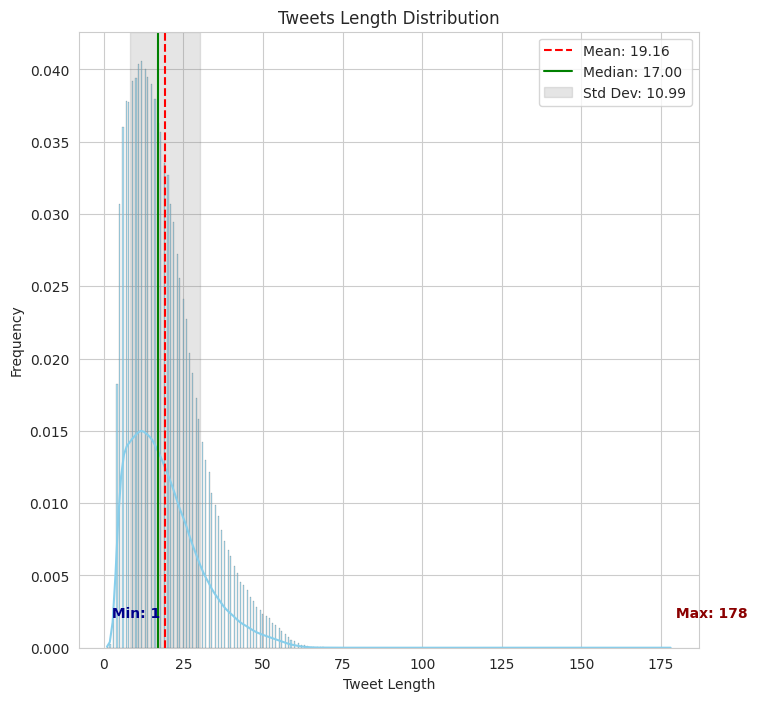

In [38]:
plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")
sns.histplot(all_tweets_length, kde=True, color='skyblue', edgecolor='black', alpha=0.7, stat='proportion')
plt.axvline(mean_tweets, color='red', linestyle='--', label=f'Mean: {mean_tweets:.2f}')
plt.axvline(median_tweets, color='green', linestyle='-', label=f'Median: {median_tweets:.2f}')
plt.axvspan(mean_tweets - std_tweets, mean_tweets + std_tweets,
            color='grey', alpha=0.2, label=f'Std Dev: {std_tweets:.2f}')
plt.text(max_tweet, plt.ylim()[1]*0.05, f' Max: {max_tweet}', color='darkred', fontweight='bold')
plt.text(min_tweet, plt.ylim()[1]*0.05, f' Min: {min_tweet}', color='darkblue', fontweight='bold')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Tweets Length Distribution')
plt.legend()

The mean tweet is 19.21 tokens long. The median is at the left of the mean, making the distribution right skeewed because most users write short tweets.

**Padding**: for this task i'm gonna use a tokenizer, choosing a max_len too high is inconvenient if most of the data falls between 0 and 75.

**Outliers**: the distribution has a long tail, but the tweets with >70 lengths have a low frequency, hence may be potential outliers.

Next i'm gonna plot the boxplot of the data.
A box plot shows the distribution of quantitative data in a way that facilitates comparisons between classes (in this case, emotion)

Text(0.5, 1.0, 'Boxplot of Tweet Length by Emotion')

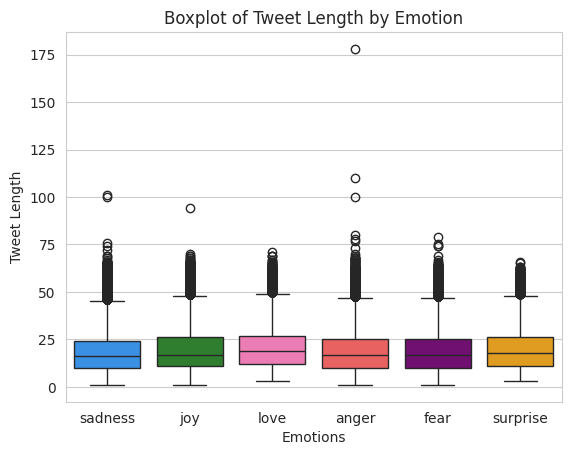

In [39]:
sns.boxplot(x="emotions",
            y=all_tweets_length,
            data=df,
            palette=custom_palette,
            hue='emotions')
plt.xlabel('Emotions')
plt.ylabel('Tweet Length')
plt.title('Boxplot of Tweet Length by Emotion')

There is no substantial differences for tweet length across different emotions.

For instance, if we consider as outliers greater with a length greater than than 75 tokens, the affected classes would be 'sadness', 'anger' and 'fear'.



## N-Gram Analysis
Analyizing n-gram could help see what words occurs most often for each class.

ONLY for N-Gram anlysis, i'll remove stop words.

In [40]:
stop_words = set(stopwords.words('english')) # I remove stop words
print(stop_words)

{'than', 'ours', "aren't", "didn't", 'about', "we'd", 'hers', 'up', 'did', 'hasn', "i'll", 'with', "he'll", 'being', 'were', 'do', "don't", 'few', "you'll", "isn't", 'him', 'himself', "hadn't", 'through', "it's", "needn't", 'their', 'ma', 'didn', 'a', "we'll", "haven't", 'into', 'ain', 'whom', "weren't", 'because', 'it', 'haven', 'to', 'further', "you're", 'at', "mustn't", 'such', 'herself', 'below', 'have', 'before', 'ourselves', 'am', 'needn', 'had', 'too', 'each', 'above', "shouldn't", 'be', "she's", 'who', 'again', 'can', 'some', 'most', 'as', 'over', 'from', 'shan', "wasn't", 'you', 'against', 'my', 'your', "it'd", 'o', 'hadn', "doesn't", 'how', 'when', "wouldn't", 'should', 'itself', 'of', 'during', 'or', "you'd", 'y', 'all', 'then', "he's", 'them', 'are', 'doing', 'yours', "shan't", 'both', 'he', "mightn't", 'its', 'm', 'mightn', 'been', 'an', 'they', 'yourselves', 'but', 'no', 'aren', 'and', 'doesn', 'isn', 's', 'where', 'yourself', 'myself', 'has', 'weren', 'her', 'so', 'in', 

Stop words are common english words and contractions. Some of these like "the" don't provide much insight about data but they are very frequent. So i remove them.

## Most Frequent Unigram
In this section i'll compute most frequent unigram that coincide with most frequent words

Text(0, 0.5, '')

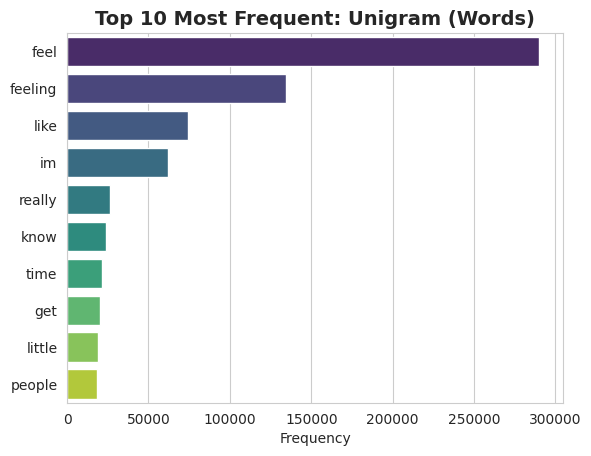

In [41]:
# Most Frequent Unigram
# 1. Get unigrams
all_unigrams = [
    word for text in df['text']
    for word in nltk.word_tokenize(str(text).lower())
    if word.isalnum() and word not in stop_words
]

# 2. Count the most common words
counts = Counter(all_unigrams).most_common(10)
words, freq = zip(*counts)

# Setup the Figure BEFORE plotting
sns.set_style("whitegrid")

# 4. Plot
ax = sns.barplot(
    x=list(freq),
    y=list(words),
    hue=list(words),
    palette='viridis',
    legend=False
)

# 5. Styling & Cleanup

plt.title(f'Top 10 Most Frequent: Unigram (Words)', fontsize=14, fontweight='bold')
plt.xlabel('Frequency')
plt.ylabel('')

"feel" and "feeling" are two words that are very frequent in the text. This **probably reflects how data was collected**, by selecting tweets that contains words like "feel" and "feeling".

In this way it's easy to collect tweets that may contains information like "i feel devastated" or "i feel angry" and associated "angry" and "sad" to emotional states.

## Most frequent Bi-grams and Trigrams

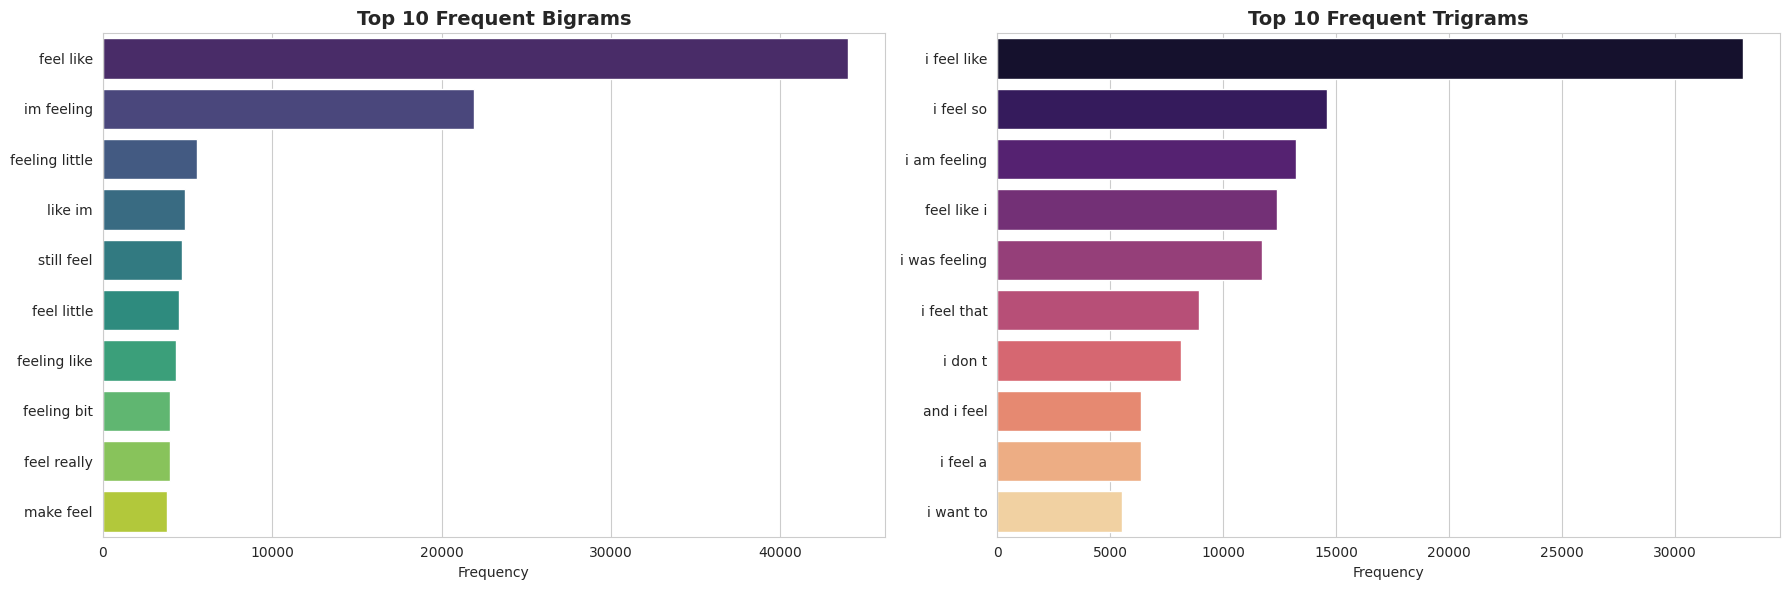

In [42]:
# Process Bigrams
all_bigrams = []

for text in df['text']:
    tokens = nltk.word_tokenize(str(text).lower())
    filtered_tokens = [t for t in tokens if t.isalnum() and t not in stop_words]
    if len(filtered_tokens) >= 2:
        all_bigrams.extend(list(ngrams(filtered_tokens, 2)))


counts_bi = Counter(all_bigrams).most_common(10)
words_bi = [' '.join(w) for w, f in counts_bi]
freq_bi = [f for w, f in counts_bi]

# Process Trigrams
all_trigrams = []
for text in df['text']:
    tokens = nltk.word_tokenize(str(text).lower())
    all_trigrams.extend(list(ngrams(tokens, 3)))

counts_tri = Counter(all_trigrams).most_common(10)
words_tri = [' '.join(w) for w, f in counts_tri]
freq_tri = [f for w, f in counts_tri]

# Create a figure with 1 row and 2 columns, wide enough for text
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("whitegrid")

# --- Left Plot: Bigrams ---
sns.barplot(
    x=freq_bi,
    y=words_bi,
    hue=words_bi,
    palette='viridis',
    legend=False,
    ax=axes[0]  # This places it in the first (left) slot
)
axes[0].set_title('Top 10 Frequent Bigrams', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency')

# --- Right Plot: Trigrams ---
sns.barplot(
    x=freq_tri,
    y=words_tri,
    hue=words_tri,
    palette='magma', # Used a different palette to visually distinguish
    legend=False,
    ax=axes[1]  # This places it in the second (right) slot
)
axes[1].set_title('Top 10 Frequent Trigrams', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency')

# Adjust layout to prevent overlapping labels
plt.tight_layout()
plt.show()

## Most frequent 4- and 5- Grams

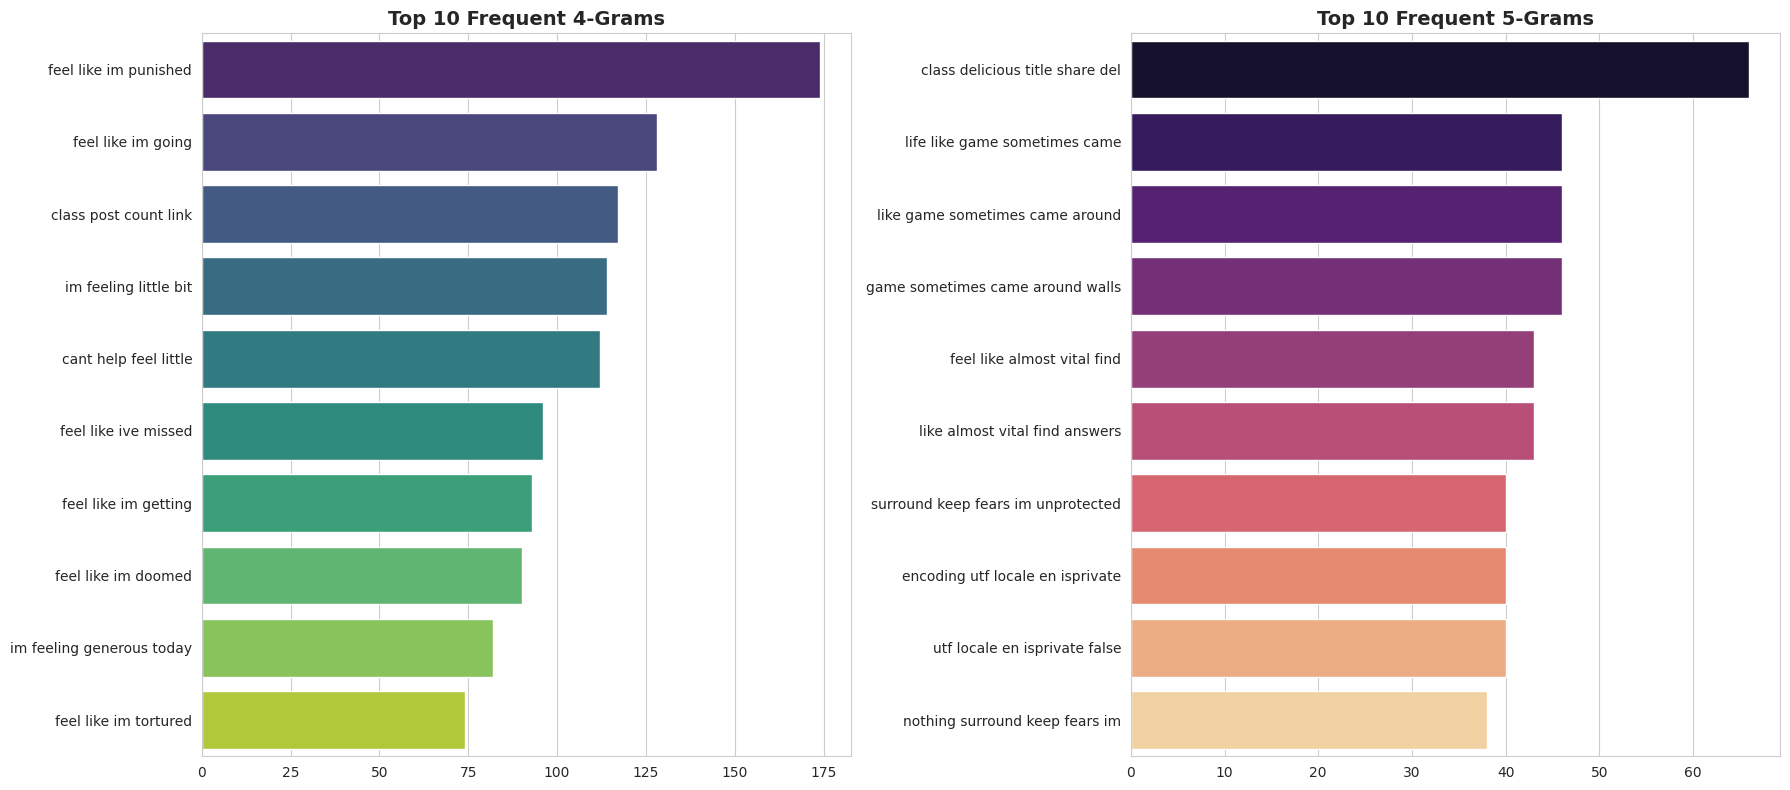

In [43]:
# --- Process 4-Grams ---
all_4grams = []
for text in df['text']:
    tokens = nltk.word_tokenize(str(text).lower())
    filtered_tokens = [t for t in tokens if t.isalnum() and t not in stop_words]
    if len(filtered_tokens) >= 4:
        all_4grams.extend(list(ngrams(filtered_tokens, 4)))

counts_four = Counter(all_4grams).most_common(10)
words_four = [' '.join(w) for w, f in counts_four]
freq_four = [f for w, f in counts_four]

# --- Process 5-Grams ---
all_5grams = []
for text in df['text']:
    tokens = nltk.word_tokenize(str(text).lower())
    filtered_tokens = [t for t in tokens if t.isalnum() and t not in stop_words]
    if len(filtered_tokens) >= 5:
        all_5grams.extend(list(ngrams(filtered_tokens, 5)))

counts_five = Counter(all_5grams).most_common(10)
words_five = [' '.join(w) for w, f in counts_five]
freq_five = [f for w, f in counts_five]

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# Left Plot: 4-Grams
sns.barplot(x=freq_four, y=words_four, hue=words_four, palette='viridis', legend=False, ax=axes[0])
axes[0].set_title('Top 10 Frequent 4-Grams', fontsize=14, fontweight='bold')

# Right Plot: 5-Grams
sns.barplot(x=freq_five, y=words_five, hue=words_five, palette='magma', legend=False, ax=axes[1])
axes[1].set_title('Top 10 Frequent 5-Grams', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Top 10 most frequent 5 and 4-grams were useful to find some noise in the data.

## N-Gram comparison between classes
- Like before, stop words are deleted

In [44]:
# Compute subsets
df_sadness = df[df['emotions'] == 'sadness']
df_joy = df[df['emotions'] == 'joy']
df_love = df[df['emotions'] == 'love']
df_anger = df[df['emotions'] == 'anger']
df_fear = df[df['emotions'] == 'fear']
df_surprise = df[df['emotions'] == 'surprise']


stop_words = set(stopwords.words('english'))

In [45]:
def get_filtered_ngrams(dataframe, n, top_n=10):
    all_grams = []
    # Use the same stop words we defined earlier
    stop_words = set(nltk.corpus.stopwords.words('english'))

    banned = {}

    for text in dataframe['text']:
        # 1. Tokenize the CURRENT row
        tokens = nltk.TweetTokenizer().tokenize(str(text).lower())

        # 2. Filter words
        filtered_tokens = [t for t in tokens if t.isalnum() and t not in stop_words and t not in banned]

        # 3. Only create ngrams if we have enough tokens
        if len(filtered_tokens) >= n:
            raw_grams = list(ngrams(filtered_tokens, n))

            all_grams.extend(raw_grams)

    counts = Counter(all_grams).most_common(top_n)

    # If the list is empty, handle it gracefully
    if not counts:
        return [], []

    words = [' '.join(w) for w, f in counts]
    freq = [f for w, f in counts]
    return words, freq

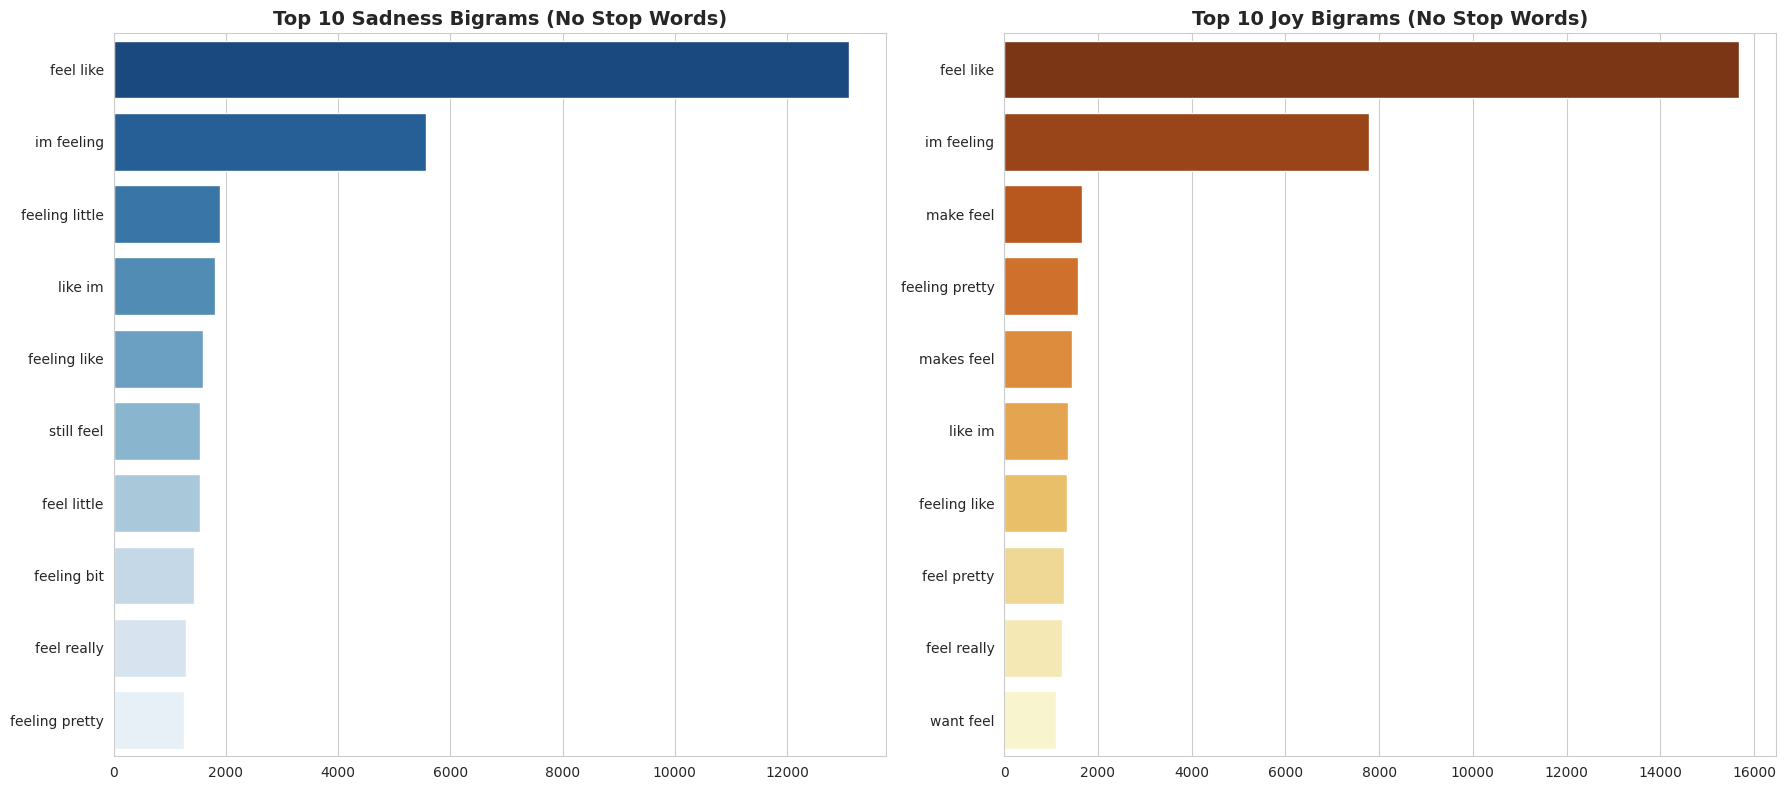

In [46]:
# Process Subsets
# We extract Bigrams (n=2) for both labels
words_bi_sad, freq_bi_sad = get_filtered_ngrams(df_sadness, 2)
words_bi_joy, freq_bi_joy = get_filtered_ngrams(df_joy, 2)

#  Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# --- Left Plot: Sadness ---
sns.barplot(x=freq_bi_sad, y=words_bi_sad, hue=words_bi_sad, palette='Blues_r', ax=axes[0], legend=False)
axes[0].set_title('Top 10 Sadness Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

# --- Right Plot: Joy ---
sns.barplot(x=freq_bi_joy, y=words_bi_joy, hue=words_bi_joy, palette='YlOrBr_r', ax=axes[1], legend=False)
axes[1].set_title('Top 10 Joy Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


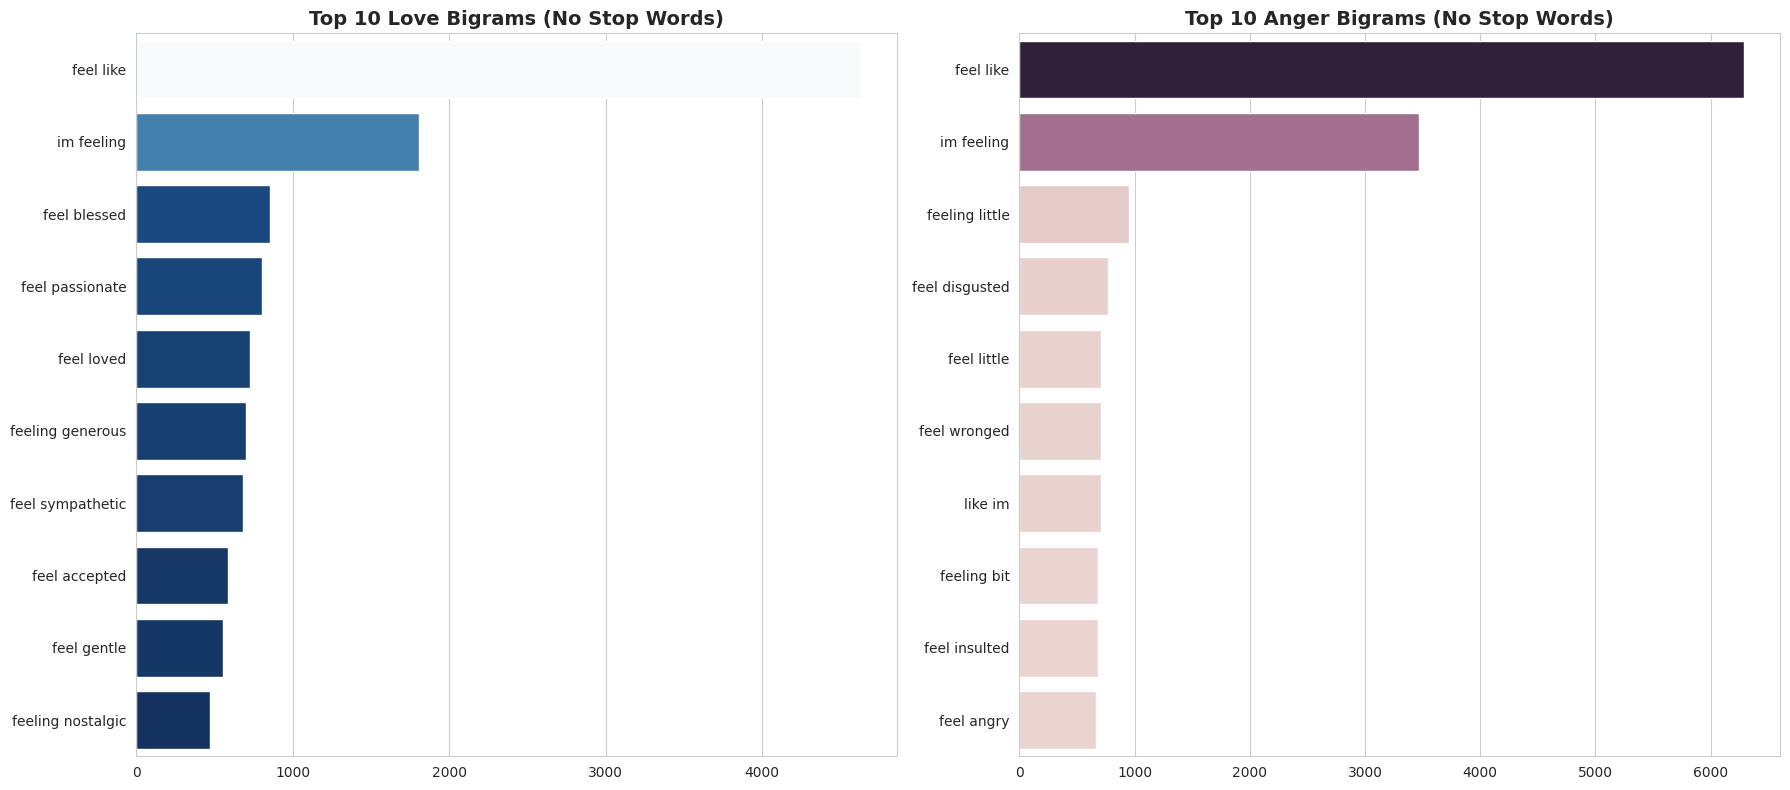

In [47]:
# Process Subsets
# We extract Bigrams (n=2) for both labels
words_bi_love, freq_bi_love = get_filtered_ngrams(df_love, 2)
words_bi_anger, freq_bi_anger = get_filtered_ngrams(df_anger, 2)

#  Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# --- Left Plot: Sadness ---
sns.barplot(y=words_bi_love, x=freq_bi_love, hue=freq_bi_love, palette='Blues_r', ax=axes[0], legend=False)
axes[0].set_title('Top 10 Love Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

# --- Right Plot: Joy ---
sns.barplot(y=words_bi_anger, x=freq_bi_anger, hue=freq_bi_anger, ax=axes[1], legend=False)
axes[1].set_title('Top 10 Anger Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


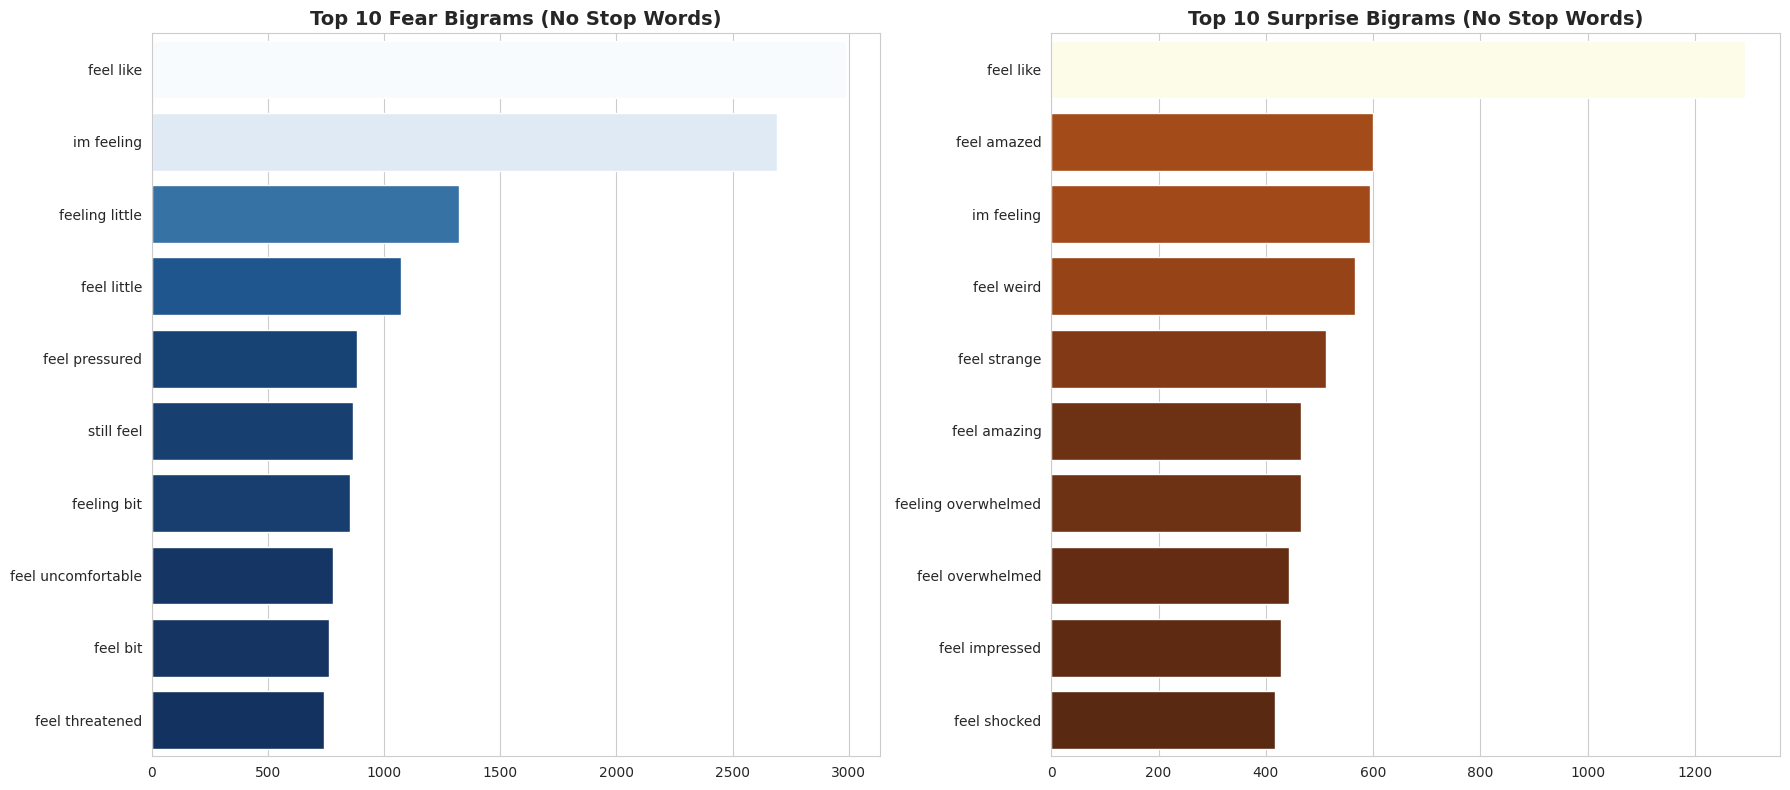

In [48]:
# Process Subsets
# We extract Bigrams (n=2) for both labels
words_bi_fear, freq_bi_fear = get_filtered_ngrams(df_fear, 2)
words_bi_surprise, freq_bi_surprise = get_filtered_ngrams(df_surprise, 2)

#  Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# --- Left Plot: Sadness ---
sns.barplot(y=words_bi_fear, x=freq_bi_fear, hue=freq_bi_fear, palette='Blues_r', ax=axes[0], legend=False)
axes[0].set_title('Top 10 Fear Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

# --- Right Plot: Joy ---
sns.barplot(y=words_bi_surprise, x=freq_bi_surprise, hue=freq_bi_surprise, palette='YlOrBr_r', ax=axes[1], legend=False)
axes[1].set_title('Top 10 Surprise Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Data Preprocessing

## Outliers Removal
Since the distribution is right skeewed, i will delete only tweets that are on the right side of the distribution. I used $3 \cdot \sigma + \mu$ to select the samples to delete

In [49]:
# Count tokens for each sample in the dataset
df['token_count'] = df['text'].apply(lambda x: len(pipeline.transform(str(x))))

In [50]:
# Remove tweets longer than 6 times the standard deviation + the mean.
outliers_del = int(3*original_std + mean_tweets)
print(f"Outlier delimiter: {outliers_del}")

print(f"Length before filtering: {len(df["text"])}")

filtered_df = df[df['token_count'] <= outliers_del]

print(f"Length after filtering: {len(filtered_df["text"])}")
print(f"Difference (deleted samples): {len(df["text"]) - len(filtered_df["text"])}")

Outlier delimiter: 52
Length before filtering: 425052
Length after filtering: 421007
Difference (deleted samples): 4045


In [51]:
filtered_df.describe()

,token_count,label_id
count,421007.000000,421007.000000
mean,18.797243,1.566475
std,10.405943,1.492278
min,1.000000,0.000000
25%,11.000000,0.000000
50%,17.000000,1.000000
75%,25.000000,3.000000
max,52.000000,5.000000


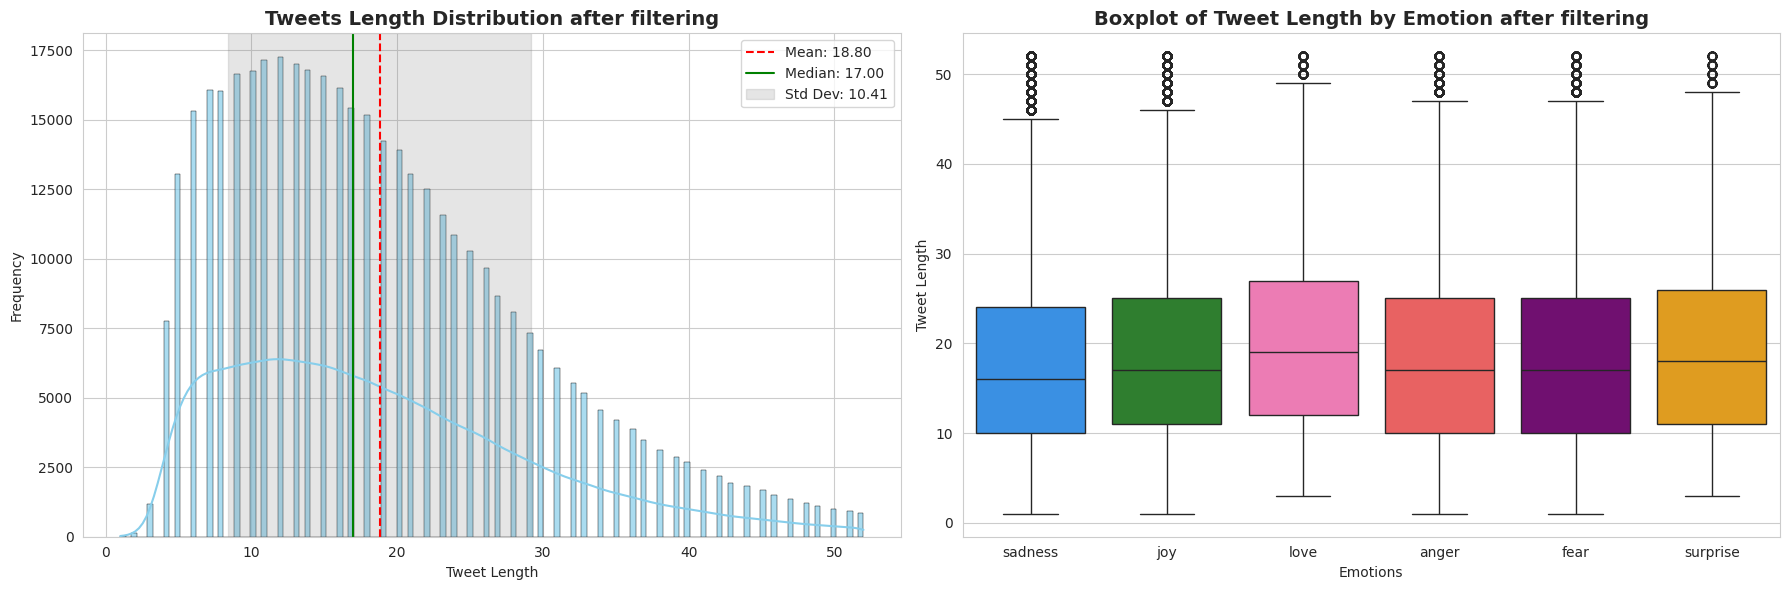

In [52]:
# Plot Tweets length distribution and boxplot after filtering

# Extract all words
all_words = []
all_tweets_length = []
for tweet in filtered_df['text']:
  tokens = pipeline.transform(tweet)
  all_words.extend(tokens)
  all_tweets_length.append(len(tokens))

mean_tweets = np.mean(all_tweets_length)
median_tweets = np.median(all_tweets_length)
std_tweets = np.std(all_tweets_length)

# After filtering the graph look like this

# Create the figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("whitegrid")

# --- Left Plot: Histogram (Index 0) ---
sns.histplot(all_tweets_length, kde=True, color='skyblue', edgecolor='black', alpha=0.7, ax=axes[0])
axes[0].axvline(mean_tweets, color='red', linestyle='--', label=f'Mean: {mean_tweets:.2f}')
axes[0].axvline(median_tweets, color='green', linestyle='-', label=f'Median: {median_tweets:.2f}')
axes[0].axvspan(mean_tweets - std_tweets, mean_tweets + std_tweets,
                color='grey', alpha=0.2, label=f'Std Dev: {std_tweets:.2f}')
axes[0].set_xlabel('Tweet Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Tweets Length Distribution after filtering', fontsize=14, fontweight='bold')
axes[0].legend()

# --- Right Plot: Boxplot (Index 1) ---
sns.boxplot(x="emotions",
            y=all_tweets_length,
            data=filtered_df,
            palette=custom_palette,
            hue='emotions',
            legend=False,
            ax=axes[1]) # This places it in the second slot
axes[1].set_xlabel('Emotions')
axes[1].set_ylabel('Tweet Length')
axes[1].set_title('Boxplot of Tweet Length by Emotion after filtering', fontsize=14, fontweight='bold')

# Automatically adjust spacing
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of Emotions after filtering')

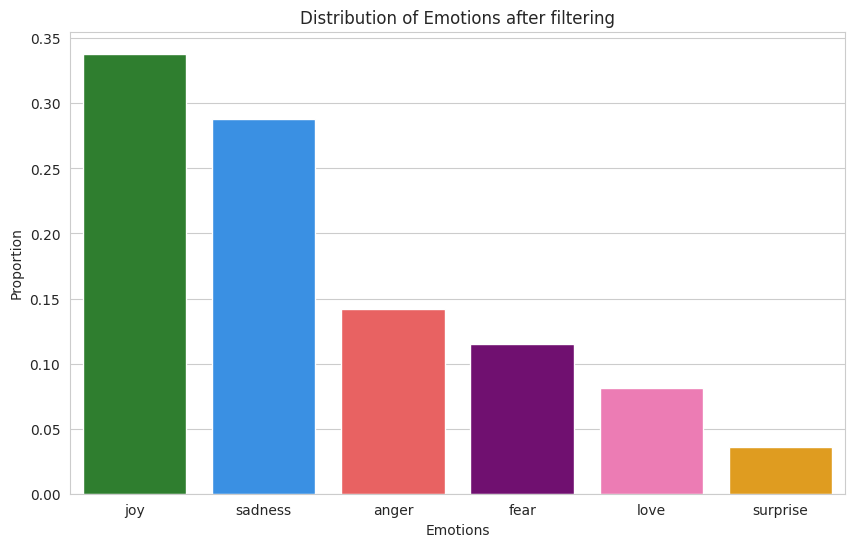

In [53]:
# PLot distribution of emotions after filtering
distributions=filtered_df['emotions'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.countplot(data=filtered_df, x='emotions', order = distributions.index, palette=custom_palette, hue='emotions', legend=False,stat='proportion')
plt.xlabel('Emotions')
plt.ylabel('Proportion')
plt.title('Distribution of Emotions after filtering')

In [54]:
df = filtered_df

## Create Dictionary
- First i count unique words in the dataset
- Then i use a dictionary that adds to each unique word an index
- I then use this dictionary to compute the sequences i.e converting every tokens to id in a tweet

In [55]:
# Create dictionary
# Count unique words in the dataset

# count words
word_counts = Counter(all_words)

print(word_counts)

# This allows you to limit vocab size later if needed
most_common_words = sorted(word_counts, key=word_counts.get, reverse=True)

# Define special tokens
# 0 is usually reserved for padding
word2idx = {"<PAD>": 0, "<UNK>": 1}

# Add unique words from your dataframe starting from index 2
for i, word in enumerate(most_common_words):
    word2idx[word] = i + 2

idx2word = {v: k for k, v in word2idx.items()}

print(f"Unique words found: {len(word2idx)}")

def tweet_to_indices(text, word2idx):
    tokens = pipeline.transform(text)
    return [word2idx.get(token, 1) for token in tokens]

del pipeline
pipeline = PreprocessPipeline()

# Clean text
df.loc[:, 'text'] = df['text'].apply(lambda tweet: pipeline.clean_text(tweet))

# Convert to indices
df.loc[:, 'sequences'] = df['text'].apply(lambda tweet: tweet_to_indices(tweet, word2idx))

Counter({'i': 665075, 'feel': 286802, 'and': 244794, 'to': 228704, 'the': 213224, 'a': 160838, 'feeling': 132906, 'of': 127727, 'that': 127702, 'my': 109185, 'in': 85011, 'it': 82734, 'like': 72844, 'so': 64478, 'for': 63204, 'im': 60704, 'have': 60245, 'me': 59044, 'but': 57483, 'is': 57087, 'was': 56496, 'this': 54041, 'am': 53634, 'with': 52141, 'not': 47250, 'be': 46113, 'about': 45718, 'on': 39948, 'as': 39925, 'you': 38399, 'just': 36592, 'at': 35379, 'when': 35366, 'or': 32684, 'all': 30528, 'because': 29748, 'more': 29690, 'do': 27196, 'really': 25529, 'can': 25409, 'up': 24002, 't': 23378, 'by': 23202, 'know': 23185, 'are': 22995, 'very': 22828, 'been': 22577, 'out': 22008, 'myself': 21239, 'what': 21226, 'if': 21033, 'time': 20892, 'how': 19699, 'get': 19308, 'little': 18923, 'will': 18677, 'had': 18450, 'now': 18437, 'from': 18255, 'being': 18010, 'people': 18009, 'they': 17719, 'would': 17592, 'he': 16366, 'her': 16162, 'want': 16012, 'one': 15718, 'still': 15627, 'them': 1

In [56]:
pd.set_option('display.max_colwidth', None)
df.head(10)

,text,emotions,token_count,label_id,sequences
0,i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here,sadness,26,0,"[2, 3, 462, 28, 13, 94, 37, 13, 85, 11, 329, 5, 55, 80, 12, 7, 1167, 5, 2938, 4, 13, 32, 263, 43, 542, 134]"
1,im alone i feel awful,sadness,5,0,"[17, 217, 2, 3, 462]"
2,ive probably mentioned this before but i really do feel proud of myself for actually keeping up with my new years resolution of monthly and weekly goals,joy,27,1,"[74, 314, 1371, 23, 168, 20, 2, 40, 39, 3, 379, 9, 50, 16, 175, 1111, 42, 25, 11, 177, 223, 4731, 9, 5386, 4, 3477, 1519]"
3,i was feeling a little low few days back,sadness,9,0,"[2, 22, 8, 7, 56, 408, 190, 164, 101]"
4,i beleive that i am much more sensitive to other peoples feelings and tend to be more compassionate,love,18,2,"[2, 16527, 10, 2, 24, 77, 38, 1812, 5, 120, 1505, 121, 4, 928, 5, 27, 38, 1045]"
5,i find myself frustrated with christians because i feel that there is constantly a talk about loving one another being there for each other and praying for each other and i have seen that this is not always the case,love,40,2,"[2, 163, 50, 331, 25, 3579, 37, 2, 3, 10, 82, 21, 778, 7, 284, 28, 352, 68, 243, 61, 82, 16, 297, 120, 4, 2155, 16, 297, 120, 4, 2, 18, 810, 10, 23, 21, 26, 105, 6, 871]"
6,i am one of those people who feels like going to the gym is only worthwhile if you can be there for an hour or more,joy,26,1,"[2, 24, 68, 9, 140, 62, 75, 115, 14, 92, 5, 6, 1415, 21, 116, 566, 52, 31, 41, 27, 82, 16, 76, 880, 35, 38]"
7,i feel especially pleased about this as this has been a long time coming,joy,14,1,"[2, 3, 278, 635, 28, 23, 30, 23, 100, 48, 7, 194, 53, 358]"
8,i was struggling with these awful feelings and was saying such sweet things about not deserving my and my sisters friendship and we agreed well she was in her car just starting to drive away when she reached out her hand,joy,41,1,"[2, 22, 1372, 25, 117, 462, 121, 4, 22, 343, 176, 237, 84, 28, 26, 6545, 11, 4, 11, 2128, 1478, 4, 78, 3243, 141, 98, 22, 12, 66, 812, 32, 317, 5, 1211, 185, 34, 98, 1733, 49, 66, 510]"
9,i feel so enraged but helpless at the same time,anger,10,3,"[2, 3, 15, 1441, 20, 285, 33, 6, 220, 53]"


## Vocabulary Construction

- Words are initialized with GloVe weight if the word is present
- otherwise they are initialized with zero.

Considering just a small subset i.e only the words present in the dataset, instead of full GloVe greatly improved the memory footpring from 480 MB (full GloVe) to about 96 MB for 80k tokens.

For Out of Vocabulary words, they are initialized with zero and their embedding are learned during the training.

Since the dataset comes from twitter, i expect to have some out of vocabulary words because of twitter slangs.

Example: "sick" in GloVe (illness) vs tweets (slang for "awesome")

# Model Architecture

In [57]:
class EmotionClassifierBaseline(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, glove_weights, distributions=None):
        super(EmotionClassifierBaseline, self).__init__()

        self.distributions = distributions # Prior initialization

        # 1. Embedding Layer
        self.embedding = nn.Embedding.from_pretrained(
            glove_weights,
            freeze=False
        )

        # 2. MLP Layers
        # Since we are averaging embeddings, the input to the first linear layer
        # is just embedding_dim (not hidden_dim * 2)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        # Add dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, text):
        # text shape: [batch_size, seq_len]

        # 1. Convert tokens to embeddings
        embedded = self.embedding(text)
        # embedded shape: [batch_size, seq_len, embedding_dim]

        # 2. SIMPLE AVERAGING (The "Baseline" part)
        # We average across the sequence length (dim=1)
        # pooled shape: [batch_size, embedding_dim]
        pooled = torch.mean(embedded, dim=1)

        # 3. Pass through MLP
        x = F.relu(self.fc1(pooled))
        x = self.dropout(x)
        logits = self.fc2(x)

        return logits

    def init_weights(self):
        # Calculate prior biases from distributions
        prior_biases = None
        if self.distributions is not None:
            freqs = torch.tensor(self.distributions, dtype=torch.float)
            # Add epsilon to prevent log(0)
            prior_biases = torch.log(freqs + 1e-9)

        for name, param in self.named_parameters():
            # Skip embedding layer
            if 'embedding' in name:
                continue

            # Xavier for all weights
            if 'weight' in name:
                nn.init.xavier_uniform_(param.data)

            # Bias Initialization
            elif 'bias' in name:
                # Apply prior to the final layer (fc2)
                if name == 'fc2.bias' and prior_biases is not None:
                    param.data.copy_(prior_biases)
                else:
                    param.data.fill_(0)


In [66]:
class EmotionClassifierLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, glove_weights, distributions=None):
        super(EmotionClassifierLSTM, self).__init__()

        self.distributions = distributions if distributions is not None else torch.ones(6)

        # Define the embedding layer
        self.embedding = nn.Embedding.from_pretrained(
            glove_weights,
            freeze=False  # Set to True if you don't want to fine-tune the embeddings
        )

        # Example Bi-LSTM setup following the embedding
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        self.attention =  nn.Linear(hidden_dim * 2, 1)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        self.init_weights()

    def forward(self, text):
        # text shape: [batch_size, seq_len]

        # 1. Convert tokens to embeddings
        embedded = self.embedding(text)
        # embedded shape: [batch_size, seq_len, embedding_dim]

        # 2. LSTM pass
        lstm_output, (hidden, cell) = self.lstm(embedded)

        # 3. Compute attention
        # pass every hidden state through the attention layer to get a score
        # energy shape [batch_size, seq_len, 1]
        energy = self.attention(lstm_output)
        # Convert scores to weights, shape [batch_size, seq_len, 1]
        weights = F.softmax(energy, dim=1)
        # compute the context vector by linear combination of weights and lsmt output
        context_vector = torch.sum(weights * lstm_output, dim=1)
        # [batch_size, hidden_dim * 2]

        # 4. Final Classification
        return self.fc(context_vector), weights

    def init_weights(self):
        """
        Applies:
          -  Xavier initialization to LSTM and Linear layers
          -  Prior initialization to last layer
        """

        # Calculate biases if distributions are provided
        prior_biases = None
        if isinstance(self.distributions, torch.Tensor):
            freqs = self.distributions.detach().clone()
        elif self.distributions is not None:
            freqs = torch.tensor(self.distributions, dtype=torch.float)
        else:
            freqs = None

        if freqs is not None:
            # Add epsilon to prevent log(0)
            prior_biases = torch.log(freqs + 1e-9)

        for name, param in self.named_parameters():
            # Skip the embedding layer (already loaded from GloVe)
            if 'embedding' in name:
                continue

            # Initialize LSTM weights
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                if name== 'fc.bias' and prior_biases is not None: # Prior Initialization
                  param.data.copy_(prior_biases)
                else:
                  param.data.fill_(0) # Initialize LSTM biases to zero

            # Initialize Linear layers (Attention and FC)
            if 'fc.weight' in name or 'attention.weight' in name:
                nn.init.xavier_uniform_(param.data)

## Attention Mechanism
I implemented **additive attention**, , which allows the model to focus on emotionally salient words while downweighting neutral context.

First energy i.e attention scores are computed:
$$
e_t = W_a \cdot h_t b_a
$$
- where $h_t$ is output of the LSTM at timestamp $t$

Then they are normalized with softmax:
$$
a_t = softmax(e_t)
$$

Context vector is computed:
$$
c = \sum a_t \cdot h_t
$$

Final output is given by:
$$
y = W_fc · c + b_f \;c
$$


# Prepare the dataset for training

In [59]:
df.head(n=10)

,text,emotions,token_count,label_id,sequences
0,i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here,sadness,26,0,"[2, 3, 462, 28, 13, 94, 37, 13, 85, 11, 329, 5, 55, 80, 12, 7, 1167, 5, 2938, 4, 13, 32, 263, 43, 542, 134]"
1,im alone i feel awful,sadness,5,0,"[17, 217, 2, 3, 462]"
2,ive probably mentioned this before but i really do feel proud of myself for actually keeping up with my new years resolution of monthly and weekly goals,joy,27,1,"[74, 314, 1371, 23, 168, 20, 2, 40, 39, 3, 379, 9, 50, 16, 175, 1111, 42, 25, 11, 177, 223, 4731, 9, 5386, 4, 3477, 1519]"
3,i was feeling a little low few days back,sadness,9,0,"[2, 22, 8, 7, 56, 408, 190, 164, 101]"
4,i beleive that i am much more sensitive to other peoples feelings and tend to be more compassionate,love,18,2,"[2, 16527, 10, 2, 24, 77, 38, 1812, 5, 120, 1505, 121, 4, 928, 5, 27, 38, 1045]"
5,i find myself frustrated with christians because i feel that there is constantly a talk about loving one another being there for each other and praying for each other and i have seen that this is not always the case,love,40,2,"[2, 163, 50, 331, 25, 3579, 37, 2, 3, 10, 82, 21, 778, 7, 284, 28, 352, 68, 243, 61, 82, 16, 297, 120, 4, 2155, 16, 297, 120, 4, 2, 18, 810, 10, 23, 21, 26, 105, 6, 871]"
6,i am one of those people who feels like going to the gym is only worthwhile if you can be there for an hour or more,joy,26,1,"[2, 24, 68, 9, 140, 62, 75, 115, 14, 92, 5, 6, 1415, 21, 116, 566, 52, 31, 41, 27, 82, 16, 76, 880, 35, 38]"
7,i feel especially pleased about this as this has been a long time coming,joy,14,1,"[2, 3, 278, 635, 28, 23, 30, 23, 100, 48, 7, 194, 53, 358]"
8,i was struggling with these awful feelings and was saying such sweet things about not deserving my and my sisters friendship and we agreed well she was in her car just starting to drive away when she reached out her hand,joy,41,1,"[2, 22, 1372, 25, 117, 462, 121, 4, 22, 343, 176, 237, 84, 28, 26, 6545, 11, 4, 11, 2128, 1478, 4, 78, 3243, 141, 98, 22, 12, 66, 812, 32, 317, 5, 1211, 185, 34, 98, 1733, 49, 66, 510]"
9,i feel so enraged but helpless at the same time,anger,10,3,"[2, 3, 15, 1441, 20, 285, 33, 6, 220, 53]"


In [60]:
class EmoDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = [torch.tensor(s) for s in sequences]
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [61]:
# Divide dataset into train and test

from sklearn.model_selection import train_test_split
# x = your sequences (list of lists of integers)
# y = your labels (0 to 5)
train_sequences, test_sequences, train_labels, test_labels = train_test_split(
    df['sequences'].values,
    df['label_id'].values,
    test_size=0.2,          # 20% for testing
    random_state=42,        # For reproducibility
    stratify=df['label_id'].values
)

In [62]:
def collate_fn(batch):
    # Sort by length (optional but helps LSTM efficiency)
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    sequences, labels = zip(*batch)

    # Pad sequences to the length of the longest one in this batch
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.stack(labels)

    return padded_sequences, labels

# Define seed for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Create the final DataLoaders
BATCH_SIZE=32

train_loader = DataLoader(
    EmoDataset(train_sequences, train_labels),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    worker_init_fn=seed_worker
)

test_loader = DataLoader(
    EmoDataset(test_sequences, test_labels),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

## Sanity Check: Overfit a sample of data
This serves as a sanity check for the data preprocessing and training loop, ensuring that labels are correctly mapped and gradients are flowing through the attention layer

In [65]:
# Test: overfit a small sample of the dataset

# 1. Load a small sample of data
small_df = df.sample(1000)
small_train_sequences, small_test_sequences, small_train_labels, small_test_labels = train_test_split(
    small_df['sequences'].values,
    small_df['label_id'].values,
    test_size=0.2,          # 20% for testing
    random_state=42,        # For reproducibility
    stratify=small_df['label_id'].values
)

small_train_loader = DataLoader(
    EmoDataset(small_train_sequences, small_train_labels),
    batch_size=8, shuffle=True, collate_fn=collate_fn
)
small_test_loader = DataLoader(
    EmoDataset(small_test_sequences, small_test_labels), batch_size=8, shuffle=False, collate_fn=collate_fn
)

# Hyperparameters
hyps = {
    "embedding_dim" : 300, # Embedding dimension
    "hidden_dim" : 256, # Hidden dimension
    "output_dim" : 6, # Output dimension
    "lr" : 3e-4, # Learning rate
    "epoch_num" : 100} # Number of training epoch

#  Model Setup
weights = load_glove_embeddings('glove.6B.300d.txt', word2idx, embedding_dim=hyps["embedding_dim"])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_test = EmotionClassifierLSTM(len(word2idx),
                                   hyps["embedding_dim"],
                                   hyps["hidden_dim"],
                                   hyps["output_dim"],
                                   weights)
model_test = model_test.to(device)
criterion_base = nn.CrossEntropyLoss()
optimizer_base = torch.optim.Adam(model_test.parameters(), lr=hyps["lr"])

def train(model, train_loader, device, optimizer, criterion):
  model.train()
  running_loss = 0.0
  correct_train = 0
  total_train = 0

  for inputs, labels in train_loader:
        # Cast labels to long (int64) which is required by CrossEntropyLoss
        inputs, labels = inputs.to(device), labels.to(device).long()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        # Correctly unpack the output of EmotionClassifierLSTM
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

  train_loss = running_loss / len(train_loader)
  train_acc = 100 * correct_train / total_train

  return train_loss, train_acc


for epoch in range(hyps["epoch_num"]):
  train_loss, train_acc = train(model_test, small_train_loader, device, optimizer_base, criterion_base)
  if train_acc == 100:
    print("Test done: no errors in the data")
    break
if train_acc < 100:
  print("Test failed: errors in the data")

/tmp/ipython-input-4001542277.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  freqs = torch.tensor(self.distributions, dtype=torch.float)


Test done: no errors in the data


# Training

In [67]:
# Define train, validate and compute top-k function
def train(model, train_loader, device, optimizer, criterion):
  model.train()
  running_loss = 0.0
  correct_train = 0
  total_train = 0

  for inputs, labels in train_loader:
        # Cast labels to long (int64) which is required by CrossEntropyLoss
        inputs, labels = inputs.to(device), labels.to(device).long()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        if hasattr(model, 'attention'):
          outputs, _ = model(inputs) # this is different for baseline and lstm model
        else:
          outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

  train_loss = running_loss / len(train_loader)
  train_acc = 100 * correct_train / total_train

  return train_loss, train_acc


def top_k_accuracy(output, target, k=2):
  """
  Computes the accuracy over the k top predictions
  """
  with torch.no_grad():
      batch_size = target.size(0)

      # Get the indices of the top k predictions
      # _, pred shape: [batch_size, k]
      _, pred = output.topk(k, 1, True, True)

      # Transpose to [k, batch_size] to compare with target
      pred = pred.t()

      # Compare pred with target (target is broadcasted)
      # correct shape: [k, batch_size] (Boolean)
      correct = pred.eq(target.view(1, -1).expand_as(pred))

      # Sum the correct predictions
      correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
      return correct_k.item()


def validate(model, test_loader, device, criterion):
  model.eval()

  val_loss = 0.0 # Validation Loss
  correct_val = 0 # Accuracy counter
  correct_topk = 0 # Top-k Accuracy counter
  total_val = 0 # Total validation loss

  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in test_loader:
          # Cast labels to long for validation as well
          inputs, labels = inputs.to(device), labels.to(device).long()

          # Get output
          if hasattr(model, 'attention'):
            outputs, _ = model(inputs) # this is different for baseline and lstm model
          else:
            outputs = model(inputs)

          # Standard Validation Loss
          loss = criterion(outputs, labels)
          val_loss += loss.item()

          # Standard Accuracy (Top-1)
          _, predicted = torch.max(outputs.data, 1)
          total_val += labels.size(0)
          correct_val += (predicted == labels).sum().item()

          # Top-2 accuracy
          correct_topk += top_k_accuracy(outputs, labels, k=2)

          all_preds.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  val_loss = val_loss / len(test_loader)
  val_acc = 100 * correct_val / total_val
  topk_acc = 100 * correct_topk / total_val
  f1_weighted = f1_score(all_labels, all_preds, average='weighted')
  f1_macro = f1_score(all_labels, all_preds, average='macro')

  return val_loss, val_acc, f1_weighted, f1_macro, topk_acc



# Train Baseline Model

## Weighted CrossEntropy Loss
Cross Entropy Loss is a loss function used for classification, defined as:
$$
\ell(\hat{\mathbf y}, t) = -\log \hat{y}_t = -\sum_i p(i)\log \hat{y}_i
$$

Since the problem is unbalanced, i weighted the cross entropy loss in such way:
1. Take che frequence i.e 1/distributon for each label
2. add it as weight in cross entropy loss: `nn.CrossEntropyLoss(weight=class_weights.to(device))`

In this way the loss function becomes:
$$
\ell(\hat{\mathbf y}, t) = - w_t \log \hat{y}_t = -\sum_i w_i \; p(i)\log \hat{y}_i
$$

This penalizes the model more if it missclassifies rarer classes rather than common ones.

In [ ]:
# 1. Hyperparameters
hyps = {
    "embedding_dim" : 300, # Embedding dimension
    "hidden_dim" : 256, # Hidden dimension
    "output_dim" : 6, # Output dimension
    "lr" : 3e-4, # Learning rate
    "wd" : 1e-5, # weight decay
    "epoch_num" : 20,
    } # Number of training epoch

# 2. Create obj glove weight matrix and model
weights = load_glove_embeddings('glove.6B.300d.txt', word2idx, embedding_dim=hyps["embedding_dim"])
model_base = EmotionClassifierBaseline(len(word2idx), # Dict
                                       hyps["embedding_dim"],
                                       hyps["hidden_dim"],
                                       hyps["output_dim"],
                                       weights, # Glove Weights
                                       distributions=list(distributions) # Prior Initialization
                                       )

# 3. Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_base = model_base.to(device)

# 4. Loss and Optimizer
# add bias to Cross Entropy Loss
freqs = torch.tensor(list(distributions))
class_weights = 1.0 / freqs
class_weights = class_weights / class_weights.sum() * len(freqs)
criterion_base = nn.CrossEntropyLoss(weight=class_weights.to(device))

optimizer_base = torch.optim.Adam(model_base.parameters(), lr=hyps['lr'], weight_decay=hyps["wd"])

✓ Found -263544/80352 words in GloVe
✗ OOV words: 343896 (428.0%)


For training:
- I implemented early stopping
- `validate()` functions produce the following metrics: Validation Loss, Validation Accuracy, F1 Score Weighted, F1 Macro Weighted and Top-2 Accuracy


In [ ]:
# Save F1-Score history, both weighted and macro
history_base = {'weighted': [], 'macro': [], 'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')
patience_counter = 0
patience_limit = 5

# Train loop
try:
  for epoch in range(hyps["epoch_num"]):
    # Calls train and validate custom functions
    train_loss, train_acc = train(model_base, train_loader, device, optimizer_base, criterion_base)
    val_loss, val_acc, f1_weighted, f1_macro, topk_acc = validate(model_base, test_loader, device, criterion_base)

    # Print metrics
    print(f'Epoch [{epoch+1}/{hyps["epoch_num"]}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%,  '
          f"Top-2 Val Accuracy: {topk_acc:.2f}%, "
          f'Weighted F1-Score: {f1_weighted:.4f},  '
          f'Macro F1-Score: {f1_macro:.4f},  ')

    # Add results to history dictionary
    history_base['weighted'].append(f1_weighted)
    history_base['macro'].append(f1_macro)
    history_base['train_loss'].append(train_loss)
    history_base['val_loss'].append(val_loss)


    # Early stopping
    patience_counter += 1
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        file_path_base = f"./best_model_baseline_v1_f1_{f1_macro:.4f}.pt"
        torch.save({
          'epoch': epoch + 1,
          'model_state_dict': model_base.state_dict(),
          'optimizer_state_dict': optimizer_base.state_dict(),
          'loss': best_val_loss,
          'history': history_base
          }, file_path_base)

    if patience_counter == patience_limit:
      print(f"Early stopping, model didn't improved for {patience_limit} epochs")
      break

except KeyboardInterrupt:
  print("\n" + "-"*30)
  print("Training manually interrupted")


Epoch [1/20], Train Loss: 1.1236, Train Acc: 55.25%, Val Loss: 0.4547, Val Acc: 86.25%,  Top-2 Val Accuracy: 95.57%, Weighted F1-Score: 0.8648,  Macro F1-Score: 0.8283,  
Epoch [2/20], Train Loss: 0.4096, Train Acc: 86.75%, Val Loss: 0.3747, Val Acc: 87.42%,  Top-2 Val Accuracy: 96.11%, Weighted F1-Score: 0.8782,  Macro F1-Score: 0.8405,  
Epoch [3/20], Train Loss: 0.3512, Train Acc: 88.06%, Val Loss: 0.3206, Val Acc: 88.38%,  Top-2 Val Accuracy: 96.68%, Weighted F1-Score: 0.8872,  Macro F1-Score: 0.8521,  
Epoch [4/20], Train Loss: 0.3080, Train Acc: 88.86%, Val Loss: 0.2910, Val Acc: 89.03%,  Top-2 Val Accuracy: 97.92%, Weighted F1-Score: 0.8927,  Macro F1-Score: 0.8582,  
Epoch [5/20], Train Loss: 0.2791, Train Acc: 89.29%, Val Loss: 0.2779, Val Acc: 89.16%,  Top-2 Val Accuracy: 98.17%, Weighted F1-Score: 0.8947,  Macro F1-Score: 0.8600,  
Epoch [6/20], Train Loss: 0.2614, Train Acc: 89.48%, Val Loss: 0.2632, Val Acc: 89.54%,  Top-2 Val Accuracy: 98.50%, Weighted F1-Score: 0.8980,  

# Train LSTM with attention
For LSTM with Attention, i'm considering a smaller **hidden dimension** because the LSTM already has more parameters than the baseline and risks to overfit the dataset.

In [ ]:
# 1. Hyperparameters
hyps = {
    "embedding_dim" : 300, # Embedding dimension
    "hidden_dim" : 128, # Hidden dimension
    "output_dim" : 6, # Output dimension
    "lr" : 3e-4, # Learning rate
    "wd" : 1e-5, #Weight Decay
    "epoch_num" : 20} # Number of training epoch

# 2. Create obj glove weight matrix and model
weights = load_glove_embeddings('glove.6B.300d.txt', word2idx, embedding_dim=hyps["embedding_dim"])
model_lstm = EmotionClassifierLSTM(len(word2idx), # Vocab Size
                                   hyps["embedding_dim"],
                                   hyps["hidden_dim"],
                                   hyps["output_dim"],
                                   weights, # Glove Weights
                                   distributions=list(distributions)) # Prior Initialization


# 3. Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_lstm = model_lstm.to(device)

# 4. Loss and Optimizer
# Add bias to CrossEntropyLoss
freqs = torch.tensor(list(distributions))
class_weights = 1.0 / freqs
class_weights = class_weights / class_weights.sum() * len(freqs)
criterion_lstm = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=hyps['lr'], weight_decay=hyps["wd"])


✓ Found -263544/80352 words in GloVe
✗ OOV words: 343896 (428.0%)


In [ ]:
# Save F1-Score history, both weighted and macro
history_lstm = {'weighted': [], 'macro': [], 'train_loss' : [], 'val_loss': []}
best_val_loss = float('inf')
patience_counter = 0
patience_limit = 5

# Train loop, calls train and validate custom functions
try:
  for epoch in range(hyps["epoch_num"]):
    # Calls train and validate custom functions
    train_loss, train_acc = train(model_lstm, train_loader, device, optimizer_lstm, criterion_lstm)
    val_loss, val_acc, f1_weighted, f1_macro, topk_acc = validate(model_lstm, test_loader, device, criterion_lstm)

    # Print metrics
    print(f'Epoch [{epoch+1}/{hyps["epoch_num"]}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%,  '
          f"Top-2 Val Accuracy: {topk_acc:.2f}%, "
          f'Weighted F1-Score: {f1_weighted:.4f},  '
          f'Macro F1-Score: {f1_macro:.4f},  ')

    # Add results to history dictionary
    history_lstm['weighted'].append(f1_weighted)
    history_lstm['macro'].append(f1_macro)
    history_lstm['train_loss'].append(train_loss)
    history_lstm['val_loss'].append(val_loss)


    # Early stopping
    patience_counter += 1
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        file_path = f"./best_model_lstm_attn_v1_f1_{f1_macro:.4f}.pt"
        torch.save({
          'epoch': epoch + 1,
          'model_state_dict': model_lstm.state_dict(),
          'optimizer_state_dict': optimizer_lstm.state_dict(),
          'loss': best_val_loss,
          'history' : history_lstm
          }, file_path)

    if patience_counter == patience_limit:
      print(f"\nEarly stopping, model didn't improved for {patience_limit} epochs")
      break


except KeyboardInterrupt:
  print("\n" + "-"*30)
  print("Training manually interrupted")
  print("-"*30)


Epoch [1/20], Train Loss: 0.2031, Train Acc: 91.23%, Val Loss: 0.1431, Val Acc: 93.31%,  Top-2 Val Accuracy: 99.24%, Weighted F1-Score: 0.9349,  Macro F1-Score: 0.9066,  
Epoch [2/20], Train Loss: 0.1364, Train Acc: 93.45%, Val Loss: 0.1374, Val Acc: 93.48%,  Top-2 Val Accuracy: 99.40%, Weighted F1-Score: 0.9365,  Macro F1-Score: 0.9083,  
Epoch [3/20], Train Loss: 0.1303, Train Acc: 93.58%, Val Loss: 0.1354, Val Acc: 93.51%,  Top-2 Val Accuracy: 99.39%, Weighted F1-Score: 0.9369,  Macro F1-Score: 0.9076,  
Epoch [4/20], Train Loss: 0.1271, Train Acc: 93.64%, Val Loss: 0.1364, Val Acc: 93.47%,  Top-2 Val Accuracy: 99.33%, Weighted F1-Score: 0.9366,  Macro F1-Score: 0.9064,  
Epoch [5/20], Train Loss: 0.1251, Train Acc: 93.70%, Val Loss: 0.1373, Val Acc: 93.49%,  Top-2 Val Accuracy: 99.42%, Weighted F1-Score: 0.9368,  Macro F1-Score: 0.9085,  
Epoch [6/20], Train Loss: 0.1231, Train Acc: 93.74%, Val Loss: 0.1356, Val Acc: 93.51%,  Top-2 Val Accuracy: 99.39%, Weighted F1-Score: 0.9370,  

# Evaluation and Metrics

I evaluated the two models with the following metrics:
- Validation Loss (Weighted Cross Entropy) is the loss computed over the set, during each epoch after training
- Top-2 Validation Accuracy is the accuracy computed over the top 2 highest probability guesses. In my case both Validation Accuracy and Top-2 Val Accuracy are high, so the model is confident. But Top-2 Val Accuracy is higher.
- F1 Score is the harmonic mean of the precision and recall, and it is used in cases where the data is unbalanced
- F1 Score can be weighted and not weighted. The not weighed (macro) is lower but a more honest evaluation because it does not take in account that data is unbalanced.
- MCC gives an high scores when the model is generally good at: correctly finding positives (TP), correctly finding negatives (TN), avoiding false positives (FP) and avoiding false negatives (FN). It is computed as:

$$MCC = \frac{TP \times TN - FP \times FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}$$

## Evaluating Baseline Model

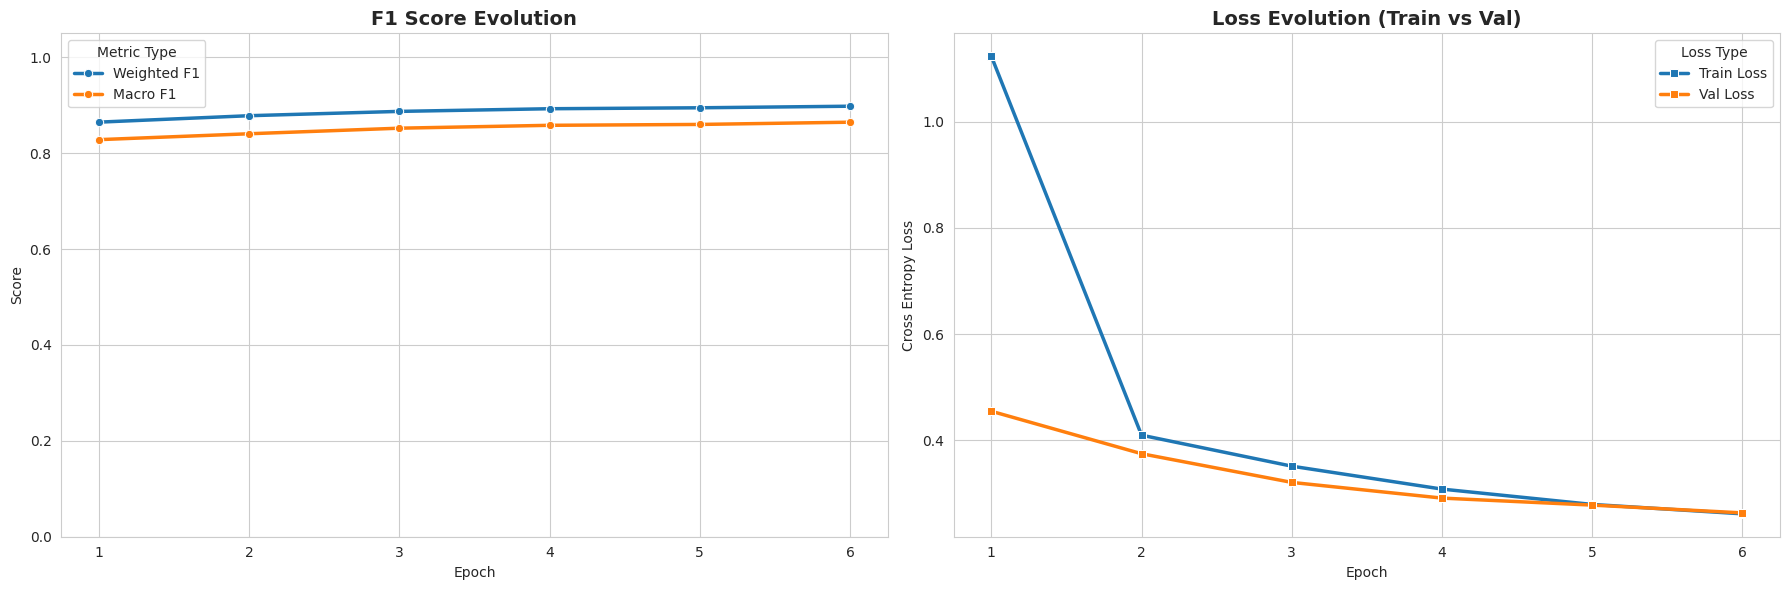

In [ ]:
# Visualize F1 weighted and F1 Macro history with Seaborn

# 1. Load the best model
model_name = "./best_model_baseline_v1_f1_0.8647.pt"

# 1.1 Save model on Google Drive
save_path = "/content/drive/My Drive/Colab Notebooks/NLP Exam/"
try:
  dest = os.path.join(save_path, model_name)
  shutil.copy(model_name, dest)
except Exception as e:
  print(e)


loaded = torch.load(model_name)
last_epoch = loaded['epoch']
model_base.load_state_dict(loaded['model_state_dict'])
history_base = loaded['history']

# 2. Prepare data for F1 Score
epochs = range(1, last_epoch + 1)
df_f1 = pd.DataFrame({
    'Epoch': list(epochs) + list(epochs),
    'Score': history_base['weighted'] + history_base['macro'],
    'Metric Type': ['Weighted F1'] * len(epochs) + ['Macro F1'] * len(epochs)
})

# 3. Prepare Data for Loss
df_loss = pd.DataFrame({
    'Epoch': list(epochs) * 2,
    'Loss': history_base['train_loss'] + history_base['val_loss'],
    'Loss Type': ['Train Loss'] * len(epochs) + ['Val Loss'] * len(epochs)
})

# 4. Create side by side plot plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("whitegrid")

# Left Plot: F1 Scores
sns.lineplot(data=df_f1, x='Epoch', y='Score', hue='Metric Type',
             marker='o', linewidth=2.5, ax=axes[0])
axes[0].set_title('F1 Score Evolution', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.05)
axes[0].set_ylabel('Score')

# Right Plot: Training & Validation Loss
sns.lineplot(data=df_loss, x='Epoch', y='Loss', hue='Loss Type',
             marker='s', linewidth=2.5, ax=axes[1], palette=['#1f77b4', '#ff7f0e'])
axes[1].set_title('Loss Evolution (Train vs Val)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Cross Entropy Loss')

# 4. Plot
plt.tight_layout()
plt.show()

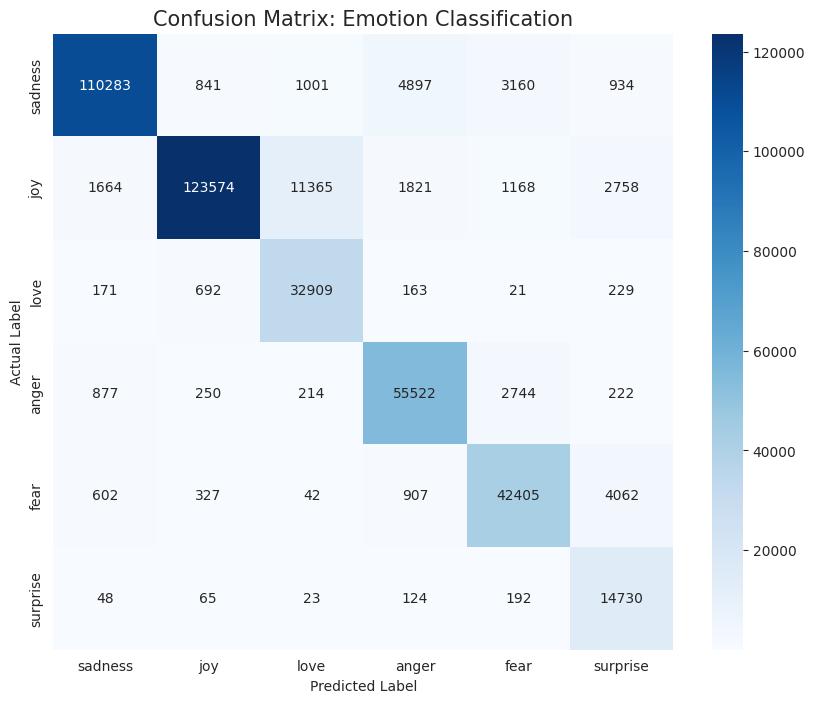

In [ ]:


def plot_cm(all_labels, all_preds, emotions_list):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))

    # Use fmt='d' for integers, cmap='Blues' for clarity
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotions_list,
                yticklabels=emotions_list)

    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix: Emotion Classification', fontsize=15)
    plt.show()

# Use it after your final validation call
all_labels = df['label_id']

model_base.eval()

def get_all_preds(data_row, model):
    predicted_idx=0
    model.eval()
    sequences = data_row['sequences']
    input_tensor = torch.tensor(sequences).unsqueeze(0).to(device)

    with torch.no_grad():
      output = model(input_tensor)
      predicted_idx = torch.argmax(output, dim=1).item()
    return predicted_idx

all_preds= df.apply(lambda row: get_all_preds(row, model_base), axis=1)

target_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
plot_cm(all_labels, all_preds, target_labels)

In [ ]:
# Classification report
print(classification_report(all_labels, all_preds, target_names=target_labels))

              precision    recall  f1-score   support

     sadness       0.97      0.91      0.94    121116
         joy       0.98      0.87      0.92    142350
        love       0.72      0.96      0.83     34185
       anger       0.88      0.93      0.90     59829
        fear       0.85      0.88      0.87     48345
    surprise       0.64      0.97      0.77     15182

    accuracy                           0.90    421007
   macro avg       0.84      0.92      0.87    421007
weighted avg       0.92      0.90      0.90    421007



In [ ]:
# Matthews Correlation Coefficient (MCC)
mc = matthews_corrcoef(all_labels, all_preds)
print(mc) # ranges between -1 and +1, if closer to +1 it is closer to perfect prediction

0.8744730131661829


## Evaluating LSTM with Attention
In this section i'll evaluate my LSTM mode with Attention.

The model is bidirectional, this helps in understanding context

In [ ]:
# 1. Load the best LSTM model
model_name = "./best_model_lstm_attn_v1_f1_0.9087.pt"

if 'model_lstm' in locals():
  # Save model on drive
  try:
    dest = os.path.join(save_path, model_name)
    shutil.copy(model_name, dest)
  except Exception as e:
    print(e)
else:
  # Load model from drive
  dest = os.path.join(save_path, model_name)
  shutil.copy(dest, model_name)
  weights = load_glove_embeddings('glove.6B.300d.txt', word2idx, embedding_dim=hyps["embedding_dim"])
  model_lstm = EmotionClassifierLSTM(len(word2idx), # Vocab Size
                                   hyps["embedding_dim"],
                                   hyps["hidden_dim"],
                                   hyps["output_dim"],
                                   weights, # Glove Weights
                                   distributions=list(distributions)) # Prior Initialization

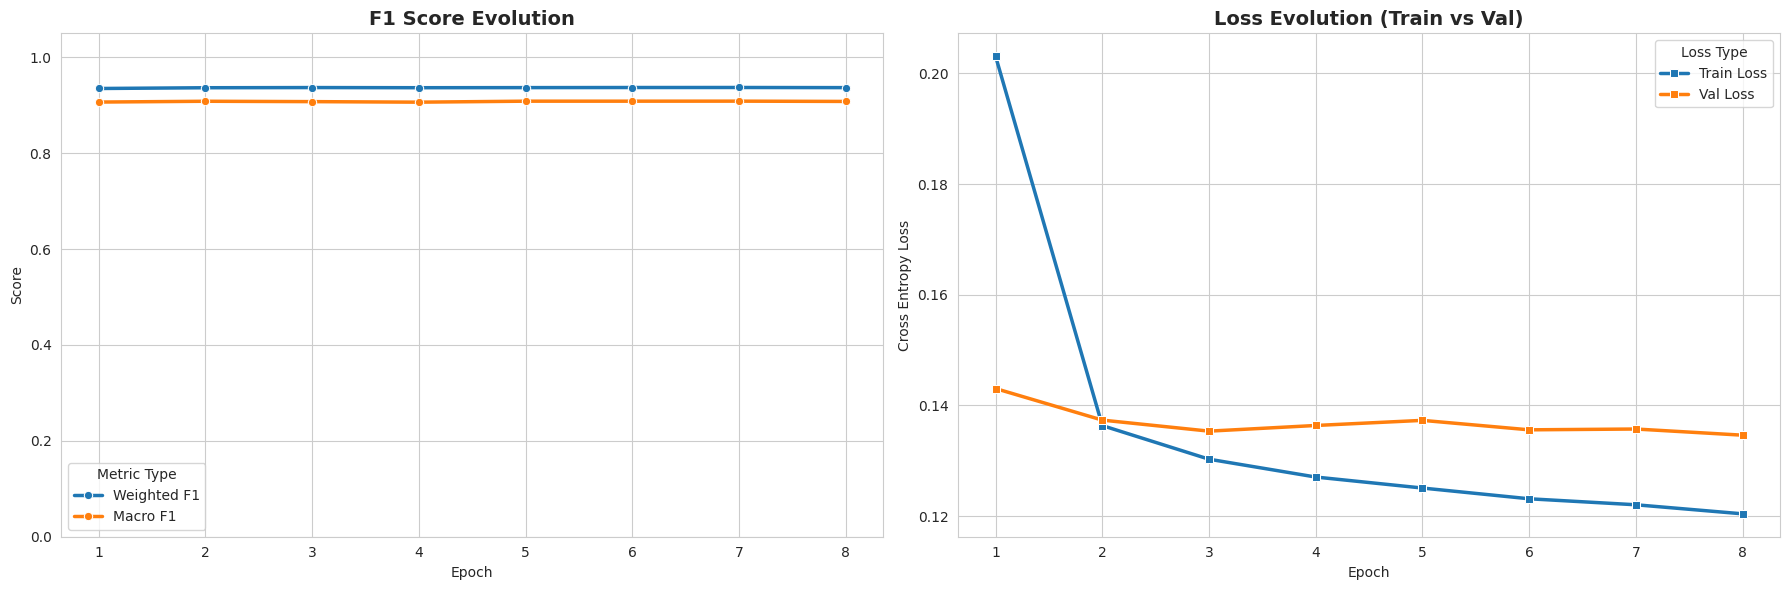

In [80]:
# Visualize F1 weighted and F1 Macro history with Seaborn
loaded = torch.load(model_name)
last_epoch = loaded['epoch']
model_lstm.load_state_dict(loaded['model_state_dict'])
model_lstm.to(device)
history_lstm = loaded['history'] if 'history' in loaded else None


# 1. Prepare data for F1
max_range = max(last_epoch+1, len(history_lstm['weighted']))
epochs = range(1, max_range)
df_f1 = pd.DataFrame({
    'Epoch': list(epochs) + list(epochs),
    'Score': history_lstm['weighted'] + history_lstm['macro'],
    'Metric Type': ['Weighted F1'] * len(epochs) + ['Macro F1'] * len(epochs)
})

# 2. Prepare Data for Loss
df_loss = pd.DataFrame({
    'Epoch': list(epochs) * 2,
    'Loss': history_lstm['train_loss'] + history_lstm['val_loss'],
    'Loss Type': ['Train Loss'] * len(epochs) + ['Val Loss'] * len(epochs)
})

# 3. Create side by side plot plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("whitegrid")

# Left Plot: F1 Scores
sns.lineplot(data=df_f1, x='Epoch', y='Score', hue='Metric Type',
             marker='o', linewidth=2.5, ax=axes[0])
axes[0].set_title('F1 Score Evolution', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.05)
axes[0].set_ylabel('Score')

# Right Plot: Training & Validation Loss
sns.lineplot(data=df_loss, x='Epoch', y='Loss', hue='Loss Type',
             marker='s', linewidth=2.5, ax=axes[1], palette=['#1f77b4', '#ff7f0e'])
axes[1].set_title('Loss Evolution (Train vs Val)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Cross Entropy Loss')

# 4. Plot
plt.tight_layout()
plt.show()

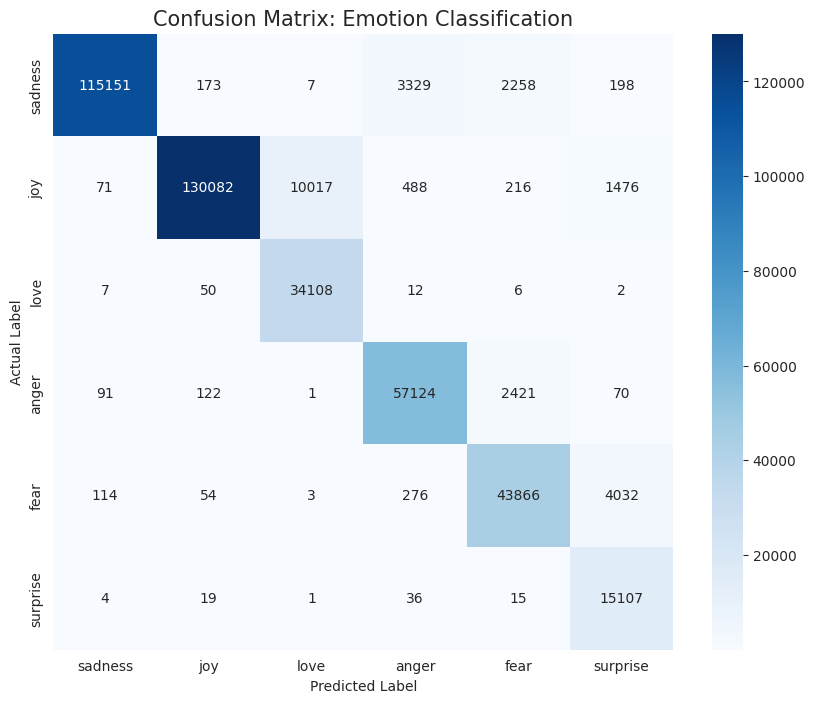

In [82]:
def plot_cm(all_labels, all_preds, emotions_list):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))

    # Use fmt='d' for integers, cmap='Blues' for clarity
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotions_list,
                yticklabels=emotions_list)

    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix: Emotion Classification', fontsize=15)
    plt.show()

# Use it after your final validation call
all_labels = df['label_id']

model_lstm.eval()

def get_all_preds(data_row, model):
    predicted_idx=0
    model.eval()
    sequences = data_row['sequences']
    input_tensor = torch.tensor(sequences).unsqueeze(0).to(device)

    with torch.no_grad():
      # Unpack the tuple to get logits and discard weights
      logits, _ = model(input_tensor)
      predicted_idx = torch.argmax(logits, dim=1).item()
    return predicted_idx

all_preds= df.apply(lambda row: get_all_preds(row, model_lstm), axis=1)

target_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
plot_cm(all_labels, all_preds, target_labels)

- The model is very confident with sadness and joy which are the classes with the highest number of sample
- The model is less confident with surprise and love
- Tweets that express "Love" are often confused for Joy but not viceversa. This make sense because they are similar emotion
- Same apply for surprise, it is most confused with fear
- Fear and Anger also in a lesser measure confused each others
- In general negative emotion (sadness, fear, anger) are often confused with negative emotion.

I suppose that the confusion for "love" and "surprise" labels come mainly from the fact that they are the classes with fewest samples and are very unbalanced respect to the other ones.

Also, the high recall comes from the use of the **Weighted** Cross Entropy Loss.

In [83]:
# Classification report
print(classification_report(all_labels, all_preds, target_names=target_labels))

              precision    recall  f1-score   support

     sadness       1.00      0.95      0.97    121116
         joy       1.00      0.91      0.95    142350
        love       0.77      1.00      0.87     34185
       anger       0.93      0.95      0.94     59829
        fear       0.90      0.91      0.90     48345
    surprise       0.72      1.00      0.84     15182

    accuracy                           0.94    421007
   macro avg       0.89      0.95      0.91    421007
weighted avg       0.95      0.94      0.94    421007



- Gnerally speaking, precision and recall are balanced and high except for love and surprise
- Love and Surprise have a low precision and an high recall

An high recall for surprise and love implies that the model is sensitive and never misses tweets for these classes, but often missclassify tweets from other classes.

The MCC score is high so the model is good. Love and Surprise are the hardest to classify since they are the ones where the model is most confused about, probably because it didn't see enough samples to understand the differences.

In [84]:
# Matthews Correlation Coefficient (MCC)
mc = matthews_corrcoef(all_labels, all_preds)
print(mc) # ranges between -1 and +1, if closer to +1 it is closer to perfect prediction

0.9224361970158833


## Class-wise attention

In [121]:
def get_attention_samples(model, data_loader, device, emotion_labels, num_samples=3):
    model.eval()
    samples = {label: [] for label in emotion_labels}

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Use your updated forward pass that returns weights
            logits, weights = model(inputs)
            probs = torch.softmax(logits, dim=1)
            confidences, predictions = torch.max(probs, dim=1)

            for i in range(len(labels)):
                true_label = emotion_labels[labels[i].item()]
                pred_label = emotion_labels[predictions[i].item()]

                # Only keep if prediction is correct and we need more samples
                if true_label == pred_label and len(samples[true_label]) < num_samples:
                    samples[true_label].append({
                        'input_ids': inputs[i],
                        'weights': weights[i],
                        'confidence': confidences[i].item()
                    })

            # Stop if we have enough samples for all classes
            if all(len(v) == num_samples for v in samples.values()):
                break
    return samples

In [122]:
# Re-create the loader with shuffling enabled
test_loader_shuff = DataLoader(
    EmoDataset(test_sequences, test_labels),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

samples = get_attention_samples(model_lstm, test_loader_shuff, device, target_labels, num_samples=5)

In [123]:
def plot_single_label_attention(samples_list, idx2word, label_name):
    """
    Plots a vertical stack of heatmaps for samples belonging to ONE specific label.
    """
    num_samples = len(samples_list)
    fig, axes = plt.subplots(num_samples, 1, figsize=(14, 3 * num_samples))

    # Ensure axes is an array even if only 1 sample exists
    if num_samples == 1: axes = [axes]

    for i, sample in enumerate(samples_list): # Iterate over sample list
        ax = axes[i]

        # 1. Get IDs and Weights, filtering out Padding (index 0)
        ids = sample['input_ids'].cpu().numpy()
        weights = sample['weights'].squeeze().cpu().numpy()

        mask = ids != 0
        words = [idx2word.get(idx, '<UNK>') for idx in ids[mask]]
        valid_weights = weights[mask].reshape(1, -1) # Reshape to 2D for heatmap

        # 2. Plot Heatmap
        sns.heatmap(valid_weights, annot=True, fmt=".2f", cmap="YlOrRd",
                    xticklabels=words, yticklabels=[], cbar=False, ax=ax)

        # 3. Titles
        ax.set_title(f"{label_name} - Confidence: {sample['confidence']:.2f}", loc='left')
        ax.tick_params(axis='x', rotation=30)

    plt.tight_layout()
    plt.show()

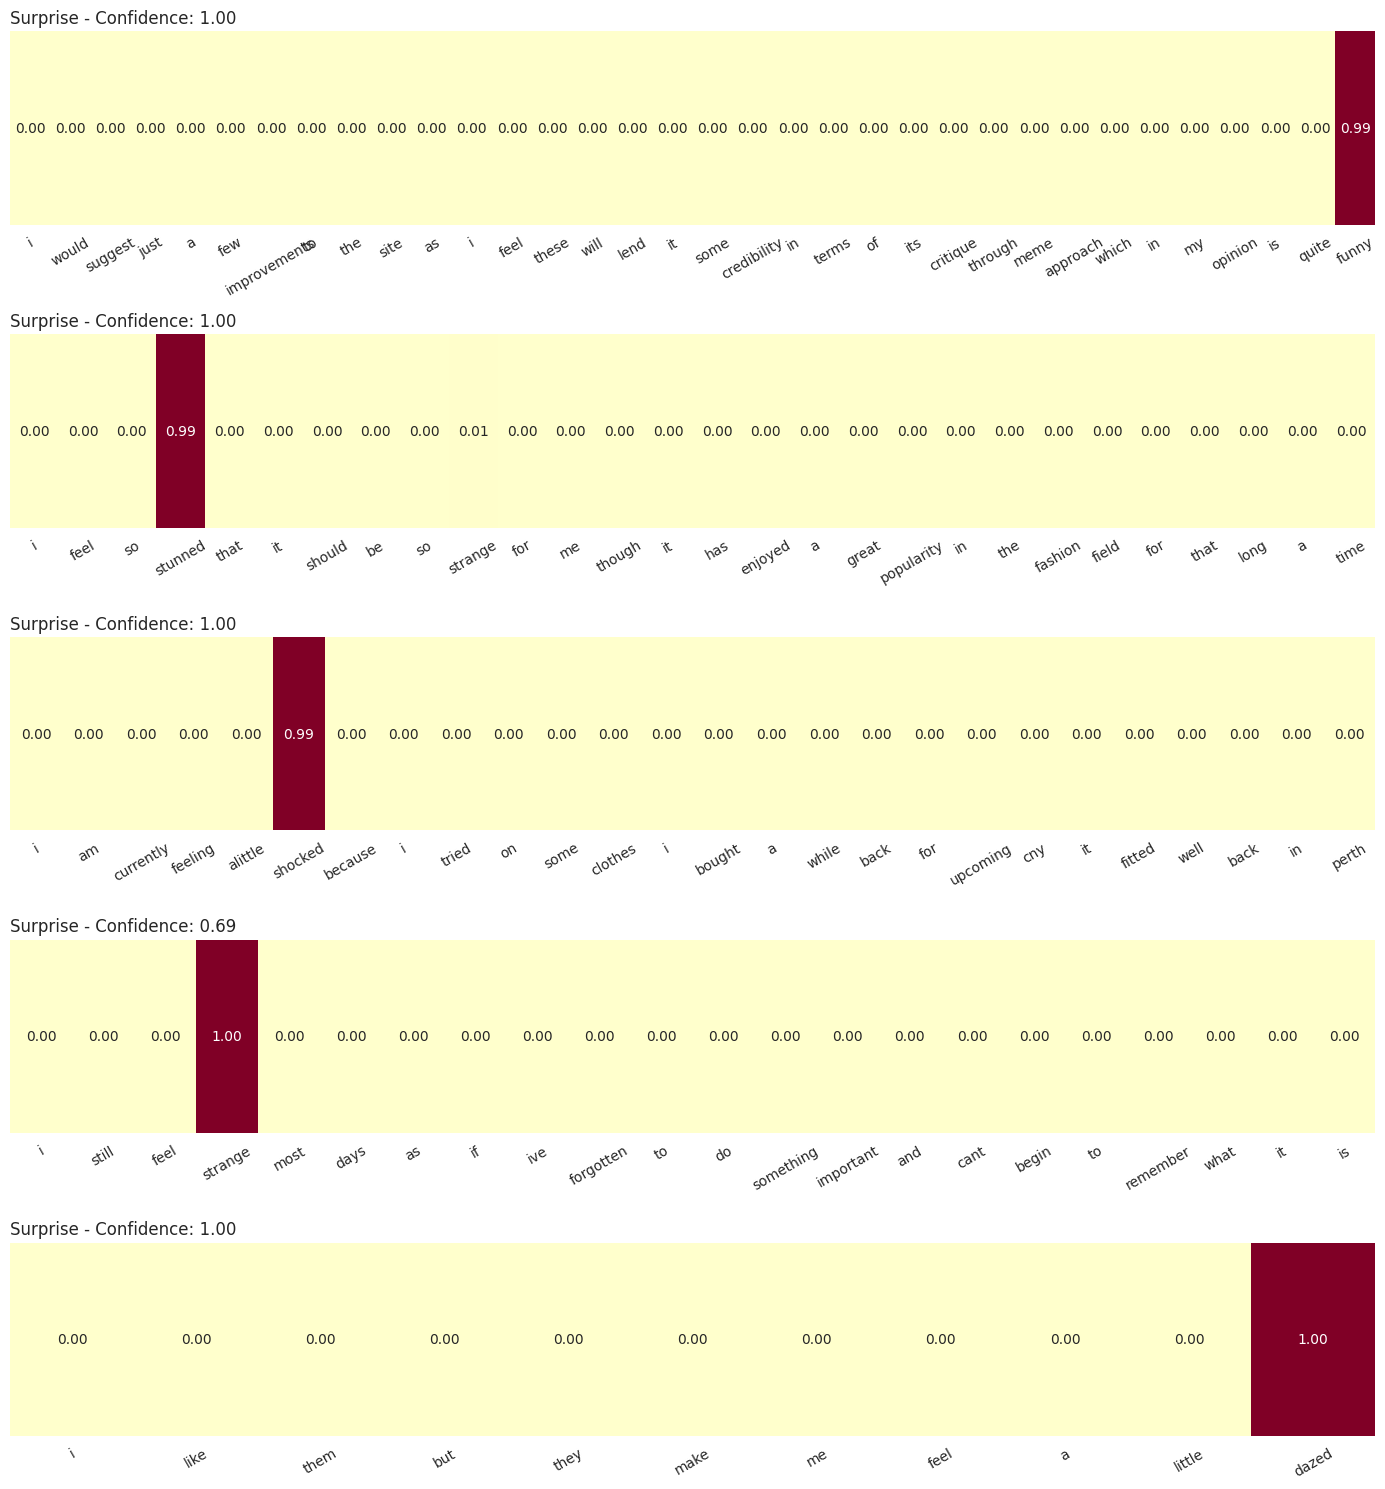

In [124]:
# Print Attention weights for Surprise
plot_single_label_attention(samples['surprise'], idx2word, "Surprise")

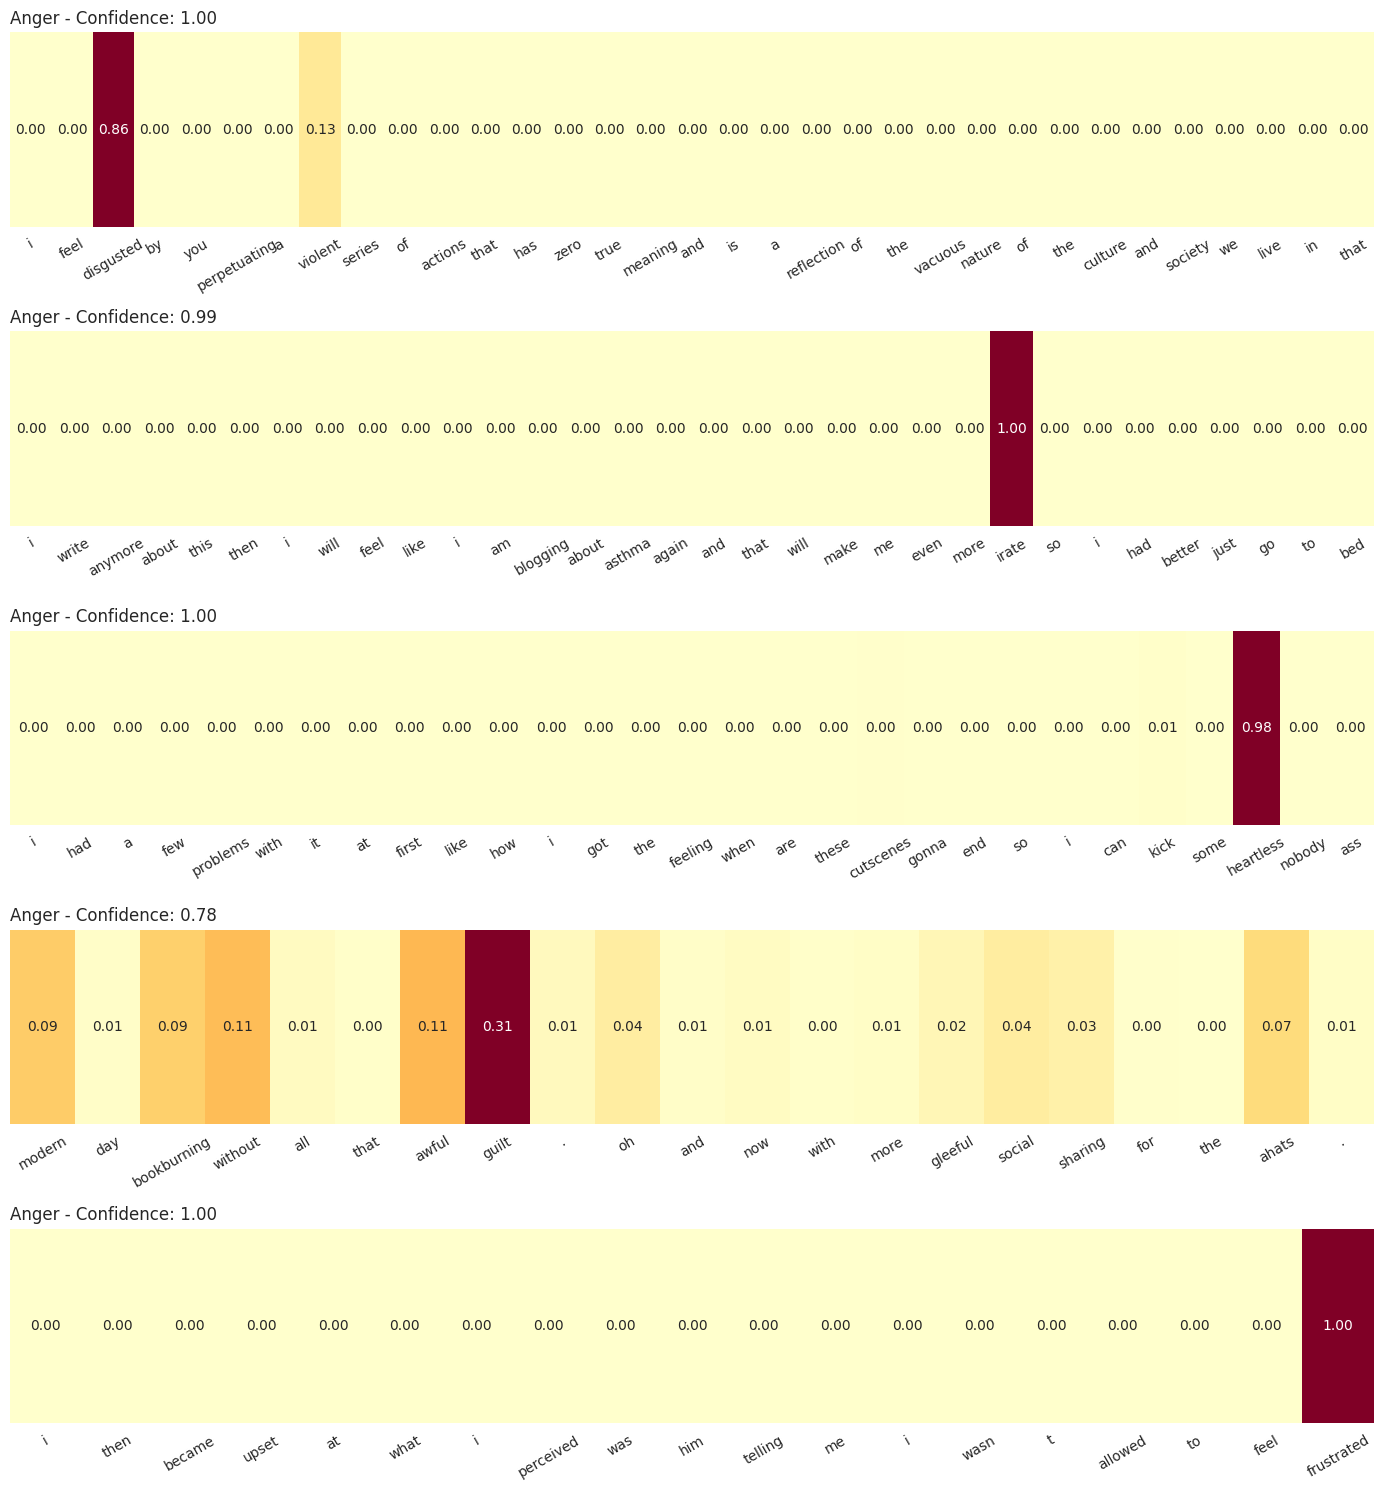

In [125]:
plot_single_label_attention(samples['anger'], idx2word, "Anger")

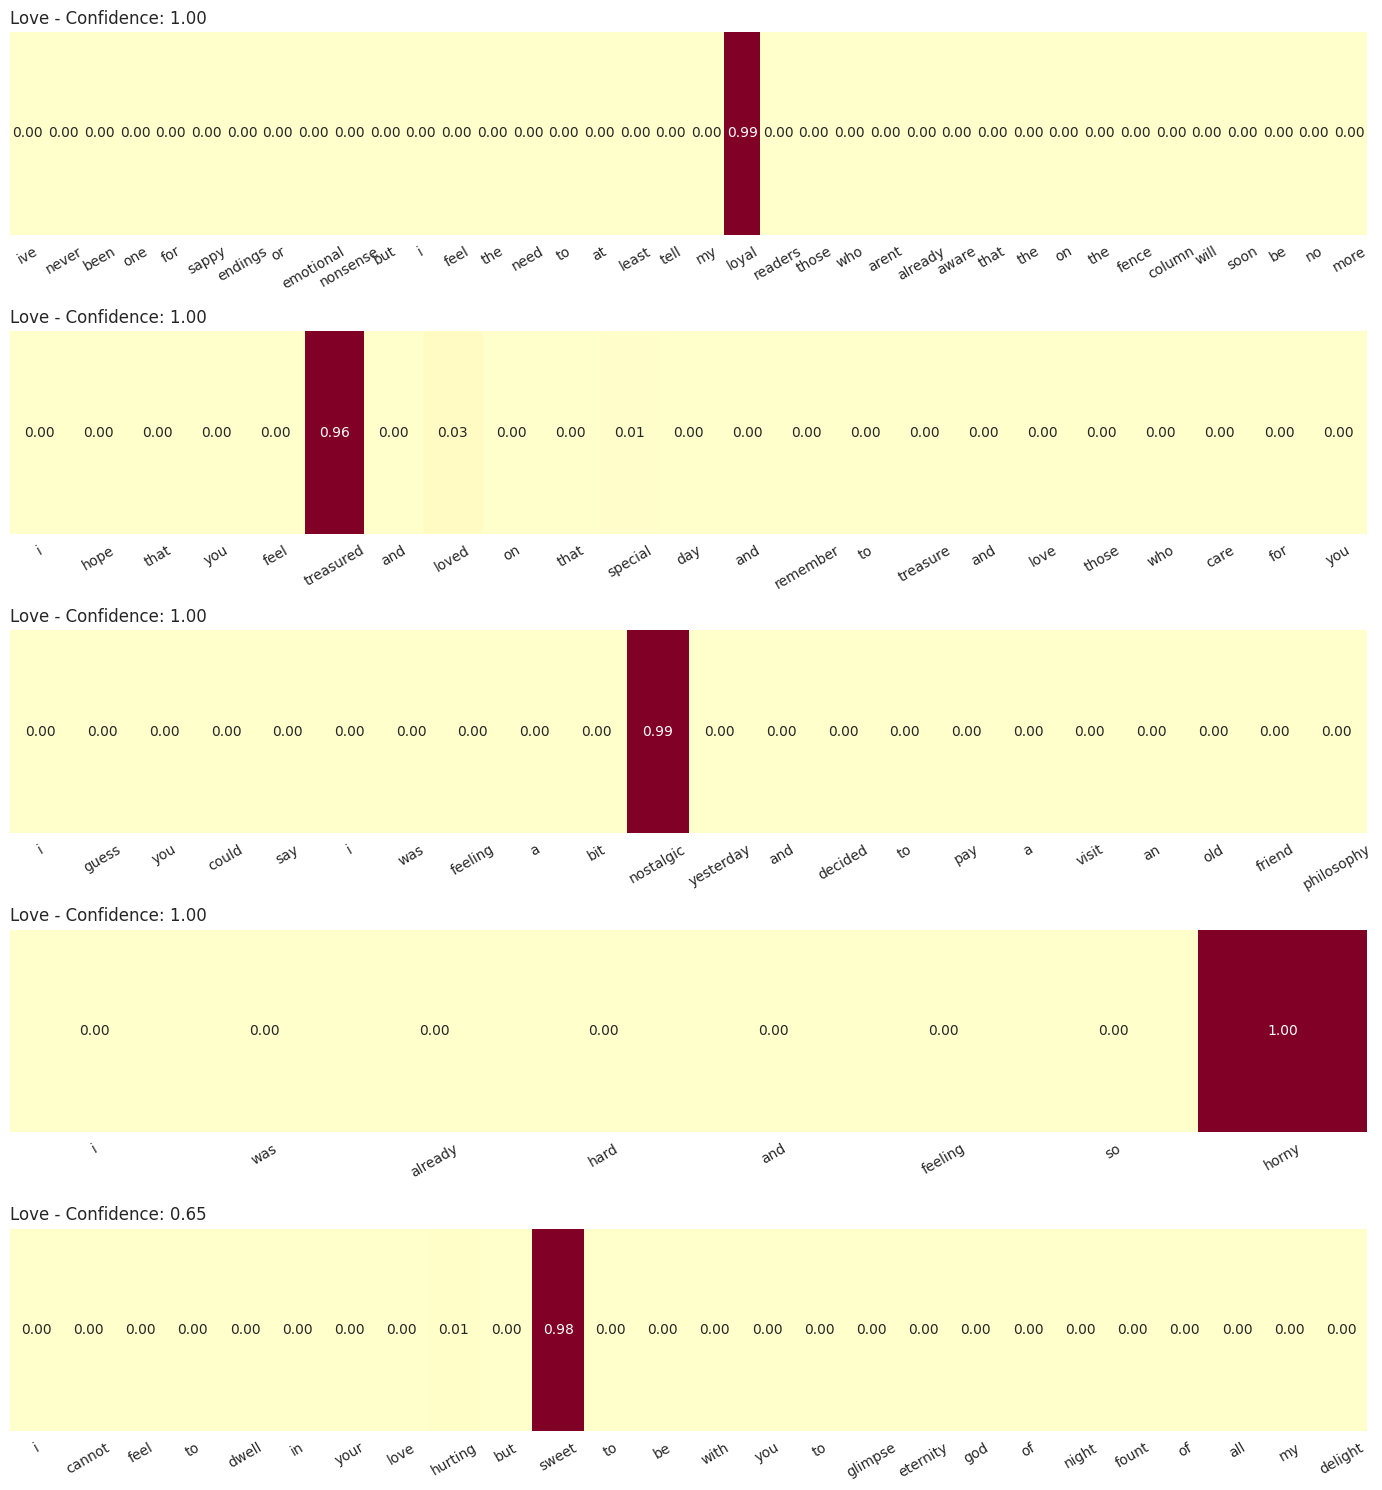

In [126]:
plot_single_label_attention(samples['love'], idx2word, "Love")

Notice that some weights are close to 1 for some words associated with the labels. For example "frustrated" for anger and "strange" for surprise.

The weight for the word "frustrated" represents the word in that context of sentence. The model ignores the surrounding words to focus on the most meaningful ones.

Now i'll compute the top 5 most important words for each label over the selected samples

In [127]:
def get_global_word_importance(model, data_loader, idx2word, device, target_labels):
    model.eval()
    # Store running sum and count: {emotion: {word: [sum_weights, count]}}
    stats = {label: defaultdict(lambda: [0.0, 0]) for label in target_labels}

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits, weights = model(inputs) # weights shape: [batch, seq_len, 1]

            weights = weights.squeeze(-1).cpu().numpy()
            inputs_numpy = inputs.cpu().numpy()
            labels_numpy = labels.cpu().numpy()

            for b in range(inputs_numpy.shape[0]):
                emotion = target_labels[labels_numpy[b]]
                for i, word_id in enumerate(inputs_numpy[b]):
                    if word_id == 0: continue # Skip padding

                    word = idx2word.get(word_id, '<UNK>')
                    stats[emotion][word][0] += weights[b, i] # add to sum
                    stats[emotion][word][1] += 1             # increment count

    # Calculate final averages
    summary = {}
    for emotion, word_dict in stats.items():
        avg_scores = {w: (val[0] / val[1]) for w, val in word_dict.items() if val[1] > 5} # Min frequency filter
        summary[emotion] = sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)[:10]

    return summary

global_top_words = get_global_word_importance(model_lstm, test_loader_shuff, idx2word, device, target_labels) # Get top 5 words for each label

In [128]:
print(global_top_words["love"])

[('sympathetic', np.float32(0.9828635)), ('supporting', np.float32(0.97699475)), ('delicate', np.float32(0.9752622)), ('generous', np.float32(0.97494346)), ('beloved', np.float32(0.9719446)), ('tender', np.float32(0.96694624)), ('gentle', np.float32(0.96408445)), ('supportive', np.float32(0.96263814)), ('fond', np.float32(0.9625697)), ('amorous', np.float32(0.9620078))]


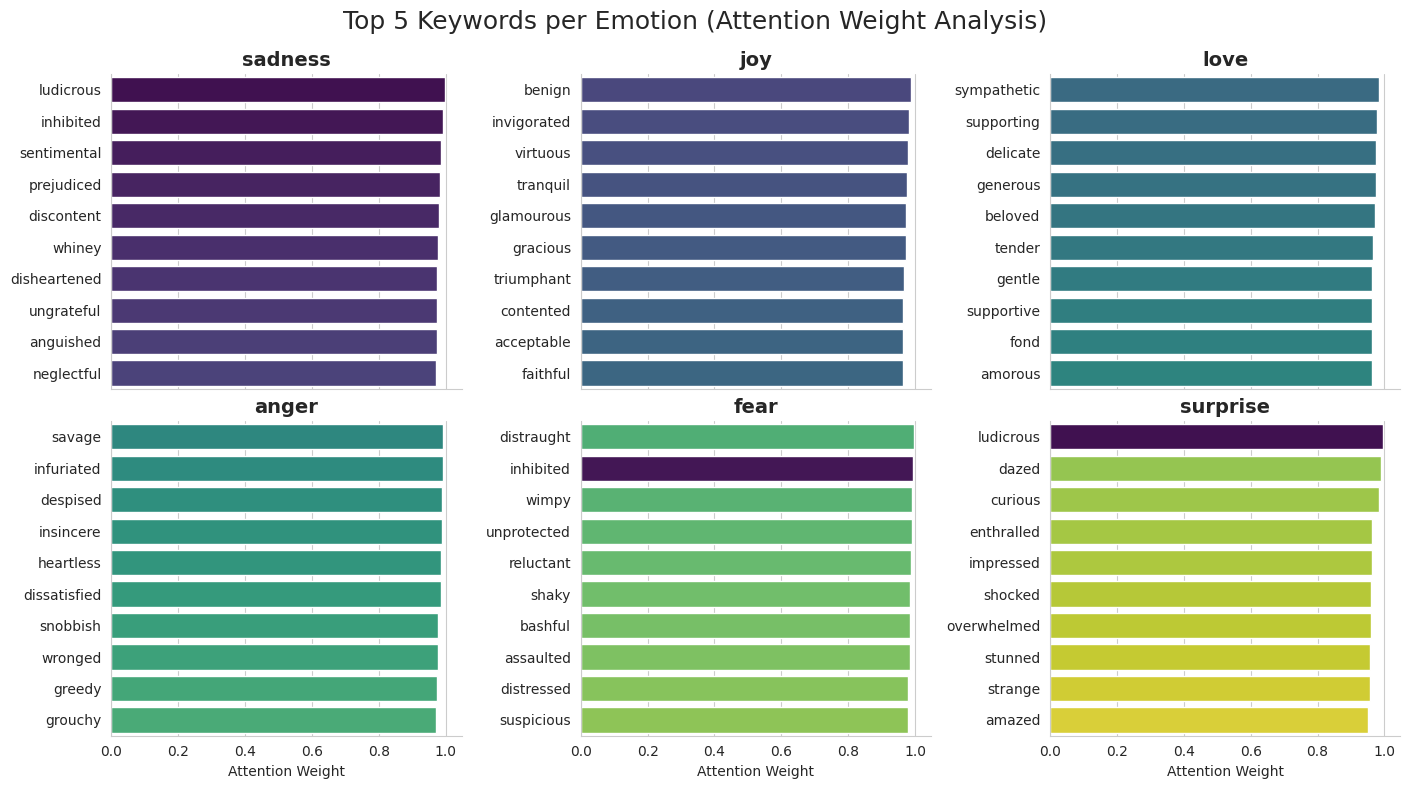

In [129]:
# Shows a Bar Plot of the top words for each label over the selected samples

# 1. Flatten the dictionary into a DataFrame
data_list = []
for emotion, top_words in global_top_words.items():
    for word, weight in top_words:
        data_list.append({
            'Emotion': emotion,
            'Word': word,
            'Average Weight': weight
        })

df_importance = pd.DataFrame(data_list)

# 2. Create the Faceted Bar Plot
sns.set_style("whitegrid")
g = sns.catplot(
    data=df_importance,
    kind="bar",
    x="Average Weight",
    y="Word",
    col="Emotion",
    col_wrap=3,           # Show 3 emotions per row
    palette="viridis",
    hue="Word",
    sharey=False,         # Important: each emotion has different words
    height=4,
    aspect=1.2
)

# 3. Final Polish
g.set_titles("{col_name}", size=14, fontweight='bold')
g.set_axis_labels("Attention Weight", "")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Top 5 Keywords per Emotion (Attention Weight Analysis)', fontsize=18)

plt.show()

# Inference Test and Error Analysis

In [ ]:
# Test inference for base model
model_lstm.eval()

# Select a random tweet from the dataset
random_row = df.sample(1).iloc[0]
tweet = random_row['text']
true_label = random_row['emotions']

# Preprocess the tweet
indices = tweet_to_indices(tweet, word2idx)

# Convert to tensor and add batch dimension (batch_size=1)
input_tensor = torch.tensor(indices).unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    output = model_lstm(input_tensor)
    predicted_idx = torch.argmax(output, dim=1).item()
    # Use emotion_to_id which maps int -> string (variable names were swapped in definition)
    predicted_label = id_to_emotion[predicted_idx]

# Display results
print(f"Tweet: {tweet}")
print(f"True Emotion: {true_label}")
print(f"Predicted Emotion: {predicted_label}")

Tweet: i feel listless and there is a huge hole in my life that used to be taken up by the store
True Emotion: sadness
Predicted Emotion: sadness


In [ ]:
# Save models to google drive

# 1. Mount Google Drive
from google.colab import drive
import shutil
drive.mount('/content/drive')



try:
  dest = os.path.join(save_path, "best_model_lstm_attn_v1_f1_0.9087.pt")
  shutil.copy("best_model_lstm_attn_v1_f1_0.9080.pt", dest)
except Exception as e:
  print(e)

try:
  dest = os.path.join(save_path, "best_model_baseline_v1_f1_0.8613.pt")
  shutil.copy("best_model_baseline_v1_f1_0.8647.pt", dest)
except Exception as e:
  print(e)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'best_model_baseline_v1_f1_0.8647.pt'


# Limitations
1. Sarcasm detection not tested
2. Short tweets (<5 words) may lack context
3. Model trained on English tweets only
4. No multi-label support (tweets with mixed emotions)
5. Internet slang evolves rapidly, this may degrade performance on very recent slang not present in training data
6. Despite weighted loss, minority classes (surprise, fear) show lower F1-scores

## Future Improvements:
- Scrape more data to balance classes distribution
- Sarcasm detection module
- Multi-label support i.e a tweet that is both sad and angry
- Consider more label
- Cross-lingual transfer: test on non-English tweets with multilingual models
- Consider using a more powerful embedding layer i.e based on BERT/RoBERTa and multi head attention
